# 0. Import Libraries and Read source data

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFECV
from sklearn.decomposition import PCA

from sklearn import metrics
from sklearn.metrics import (
    f1_score, precision_score, recall_score, average_precision_score,
    accuracy_score, confusion_matrix, classification_report, precision_recall_curve, make_scorer
)

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import randint, uniform,loguniform
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [4]:
samples = pd.read_csv('./application_samples.csv')

In [5]:
features = pd.read_csv('./credit_features.csv')

In [6]:
data_dict = pd.read_csv('./data_dictionary.csv')

# 1. EDA

In [7]:
data_dict

,Name,Description
0,UID,unique identifier
1,Application Date,Date of loan application
2,Amount,Amount requested by applicant
3,Term,Repayment period requested by applicant
4,Employment Type,Stated employment
5,LoanPurpose,Purpose of loan
6,Success,Applicant successful
7,ALL_AgeOfOldestAccount,Age of oldest accounts
8,ALL_AgeOfYoungestAccount,Age of youngest accounts
9,ALL_Count,No. of accounts


In [8]:
samples.head()

,UID,ApplicationDate,Amount,Term,EmploymentType,LoanPurpose,Success
0,4921736,03/07/2020,2000,60,Employed - full time,Unexpected bills,0
1,1241981,04/02/2020,3000,60,Employed - full time,Starting new bussniess,0
2,5751748,02/08/2020,20000,60,Employed - full time,Business capital,0
3,7163425,23/09/2020,20000,60,Self employed,New business venture,0
4,227377,01/01/2020,5000,36,Employed - full time,car,0


In [9]:
samples.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8847 entries, 0 to 8846
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   UID              8847 non-null   int64 
 1   ApplicationDate  8847 non-null   object
 2   Amount           8847 non-null   int64 
 3   Term             8847 non-null   int64 
 4   EmploymentType   8847 non-null   object
 5   LoanPurpose      8847 non-null   object
 6   Success          8847 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 483.9+ KB


In [10]:
samples['UID'].nunique()

8847

In [11]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8847 entries, 0 to 8846
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   UID                                   8847 non-null   int64  
 1   ALL_AgeOfOldestAccount                8847 non-null   int64  
 2   ALL_AgeOfYoungestAccount              8847 non-null   int64  
 3   ALL_Count                             8847 non-null   int64  
 4   ALL_CountActive                       8847 non-null   int64  
 5   ALL_CountClosedLast12Months           8847 non-null   int64  
 6   ALL_CountDefaultAccounts              8847 non-null   int64  
 7   ALL_CountOpenedLast12Months           8847 non-null   int64  
 8   ALL_CountSettled                      8847 non-null   int64  
 9   ALL_MeanAccountAge                    8847 non-null   float64
 10  ALL_SumCurrentOutstandingBal          8847 non-null   int64  
 11  ALL_SumCurrentOut

In [12]:
# since this column has only one unique value across all rows.
# and it doesn’t provide any useful information for modeling, as it has no variability.
# Dropping it can simplify the dataset without losing any predictive power.
print(features['ALL_TimeSinceMostRecentDefault'].nunique())
features = features.drop(columns=['ALL_TimeSinceMostRecentDefault'])

1


In [13]:
features.describe()

,UID,ALL_AgeOfOldestAccount,ALL_AgeOfYoungestAccount,ALL_Count,ALL_CountActive,ALL_CountClosedLast12Months,ALL_CountDefaultAccounts,ALL_CountOpenedLast12Months,ALL_CountSettled,ALL_MeanAccountAge,ALL_SumCurrentOutstandingBal,ALL_SumCurrentOutstandingBalExcMtg,ALL_WorstPaymentStatusActiveAccounts
count,8.847000e+03,8847.000000,8847.000000,8847.000000,8847.000000,8847.000000,8847.000000,8847.000000,8847.000000,8847.000000,8.847000e+03,8847.000000,8847.000000
mean,4.753101e+06,162.694021,8.587431,17.515316,9.258506,1.589691,1.380355,2.453487,8.231491,57.285159,5.416258e+04,12858.636148,2.057647
std,2.766232e+06,94.569878,13.081866,13.900171,4.896900,2.611921,2.749450,2.964837,11.419963,29.132180,1.074432e+05,17756.568825,3.139938
min,2.160090e+05,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000
25%,2.376933e+06,100.000000,2.000000,9.000000,6.000000,0.000000,0.000000,1.000000,2.000000,38.770000,3.396000e+03,2438.000000,0.000000
50%,4.463541e+06,151.000000,5.000000,15.000000,9.000000,1.000000,0.000000,2.000000,5.000000,53.120000,1.267000e+04,8336.000000,0.000000
75%,7.194733e+06,212.000000,10.000000,22.000000,12.000000,2.000000,2.000000,3.000000,10.000000,71.530000,6.171250e+04,17990.500000,7.000000
max,9.684478e+06,999.000000,258.000000,233.000000,43.000000,60.000000,23.000000,62.000000,215.000000,304.000000,4.004808e+06,581415.000000,7.000000


In [14]:
features['ALL_WorstPaymentStatusActiveAccounts'].nunique()

9

## 1-1. Generate Full_df merging application_samples & features

In [42]:
full_df = pd.merge(samples, features, on = 'UID')

In [16]:
full_df.head()

,UID,ApplicationDate,Amount,Term,EmploymentType,LoanPurpose,Success,ALL_AgeOfOldestAccount,ALL_AgeOfYoungestAccount,ALL_Count,ALL_CountActive,ALL_CountClosedLast12Months,ALL_CountDefaultAccounts,ALL_CountOpenedLast12Months,ALL_CountSettled,ALL_MeanAccountAge,ALL_SumCurrentOutstandingBal,ALL_SumCurrentOutstandingBalExcMtg,ALL_WorstPaymentStatusActiveAccounts
0,4921736,03/07/2020,2000,60,Employed - full time,Unexpected bills,0,162,17,18,12,0,0,0,6,70.94,68555,15019,0
1,1241981,04/02/2020,3000,60,Employed - full time,Starting new bussniess,0,266,30,14,10,0,4,0,4,104.79,2209,2209,7
2,5751748,02/08/2020,20000,60,Employed - full time,Business capital,0,90,52,4,2,0,1,0,2,68.25,5108,5108,7
3,7163425,23/09/2020,20000,60,Self employed,New business venture,0,163,19,14,6,1,1,0,8,67.50,25738,25738,0
4,227377,01/01/2020,5000,36,Employed - full time,car,0,129,2,38,19,4,9,8,19,56.45,5801,5801,7


In [17]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8847 entries, 0 to 8846
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   UID                                   8847 non-null   int64  
 1   ApplicationDate                       8847 non-null   object 
 2   Amount                                8847 non-null   int64  
 3   Term                                  8847 non-null   int64  
 4   EmploymentType                        8847 non-null   object 
 5   LoanPurpose                           8847 non-null   object 
 6   Success                               8847 non-null   int64  
 7   ALL_AgeOfOldestAccount                8847 non-null   int64  
 8   ALL_AgeOfYoungestAccount              8847 non-null   int64  
 9   ALL_Count                             8847 non-null   int64  
 10  ALL_CountActive                       8847 non-null   int64  
 11  ALL_CountClosedLa

In [18]:
# There's no NaN value.
full_df.isna().sum()

,0
UID,0
ApplicationDate,0
Amount,0
Term,0
EmploymentType,0
LoanPurpose,0
Success,0
ALL_AgeOfOldestAccount,0
ALL_AgeOfYoungestAccount,0
ALL_Count,0


In [43]:
full_df['ApplicationDate'] = pd.to_datetime(full_df['ApplicationDate'], format='%d/%m/%Y')

In [44]:
full_df.head()

,UID,ApplicationDate,Amount,Term,EmploymentType,LoanPurpose,Success,ALL_AgeOfOldestAccount,ALL_AgeOfYoungestAccount,ALL_Count,ALL_CountActive,ALL_CountClosedLast12Months,ALL_CountDefaultAccounts,ALL_CountOpenedLast12Months,ALL_CountSettled,ALL_MeanAccountAge,ALL_SumCurrentOutstandingBal,ALL_SumCurrentOutstandingBalExcMtg,ALL_WorstPaymentStatusActiveAccounts
0,4921736,2020-07-03,2000,60,Employed - full time,Unexpected bills,0,162,17,18,12,0,0,0,6,70.94,68555,15019,0
1,1241981,2020-02-04,3000,60,Employed - full time,Starting new bussniess,0,266,30,14,10,0,4,0,4,104.79,2209,2209,7
2,5751748,2020-08-02,20000,60,Employed - full time,Business capital,0,90,52,4,2,0,1,0,2,68.25,5108,5108,7
3,7163425,2020-09-23,20000,60,Self employed,New business venture,0,163,19,14,6,1,1,0,8,67.50,25738,25738,0
4,227377,2020-01-01,5000,36,Employed - full time,car,0,129,2,38,19,4,9,8,19,56.45,5801,5801,7


# 2. Preprocessing - Feature Engineering

## Preprocessing Object type
ApplicationDate, EmploymentType and LoanPurpose need to be preprocessed since they are the object types which is inappropriate type when we use them as an input of machine learning.
- 1 'ApplicationDate' : Transform into datetime format, extract year, month, and day as separate columns, extract the day of the week and calculate the number of days since the application date to use all of them as features.
- 2 'EmploymentType' : Use one-hot encoding which is a basic encoding technique when we have a few unique values in categories
- 3 'LoanPurpose': Has more than 2,000 different unique values.


### 1. samples['ApplicationDate]

In [45]:
# Assuming `ApplicationDate` is in the 'DD/MM/YYYY' format
full_df['ApplicationDate'] = pd.to_datetime(full_df['ApplicationDate'], format='%d/%m/%Y')

In [46]:
# Extracting year, month, and day as separate columns
# we don't need year since it's just all 2020
# samples['ApplicationYear'] = samples['ApplicationDate'].dt.year
full_df['ApplicationMonth'] = full_df['ApplicationDate'].dt.month
full_df['ApplicationDay'] = full_df['ApplicationDate'].dt.day

# Extracting the day of the week (0=Monday, 6=Sunday)
full_df['ApplicationDayOfWeek'] = full_df['ApplicationDate'].dt.dayofweek

# Calculate the number of days since the application date
current_date = datetime.now()
full_df['DaysSinceApplication'] = (current_date - full_df['ApplicationDate']).dt.days

In [47]:
# Sine and cosine encoding for ApplicationMonth (1 to 12)
full_df['ApplicationMonth_sin'] = np.sin(2 * np.pi * full_df['ApplicationMonth'] / 12)
full_df['ApplicationMonth_cos'] = np.cos(2 * np.pi * full_df['ApplicationMonth'] / 12)

# Sine and cosine encoding for ApplicationDay (1 to 31)
full_df['ApplicationDay_sin'] = np.sin(2 * np.pi * full_df['ApplicationDay'] / 31)
full_df['ApplicationDay_cos'] = np.cos(2 * np.pi * full_df['ApplicationDay'] / 31)

# Sine and cosine encoding for ApplicationDayOfWeek (1 to 7)
full_df['ApplicationDayOfWeek_sin'] = np.sin(2 * np.pi * full_df['ApplicationDayOfWeek'] / 7)
full_df['ApplicationDayOfWeek_cos'] = np.cos(2 * np.pi * full_df['ApplicationDayOfWeek'] / 7)

In [48]:
full_df.drop(columns=['ApplicationDate','ApplicationMonth','ApplicationDay','ApplicationDayOfWeek'], inplace= True)

### 2. ['EmploymentType]

In [49]:
full_df['EmploymentType'].value_counts()

,count
EmploymentType,
Employed - full time,7714
Employed - part time,570
Self employed,418
Retired,145


In [50]:
# Apply get_dummies to the 'EmploymentType' column only, then concatenate with the rest of the DataFrame.
employment_type_dummies = pd.get_dummies(full_df['EmploymentType'], prefix='EmploymentType').astype(int)

In [51]:
employment_type_dummies

,EmploymentType_Employed - full time,EmploymentType_Employed - part time,EmploymentType_Retired,EmploymentType_Self employed
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,0,0,0,1
4,1,0,0,0
...,...,...,...,...
8842,1,0,0,0
8843,1,0,0,0
8844,1,0,0,0
8845,0,0,0,1


In [52]:
# Drop the original 'EmploymentType' column from full_df
full_df = full_df.drop(columns=['EmploymentType'])

# Concatenate the dummy variables with the original DataFrame
full_df = pd.concat([full_df, employment_type_dummies], axis=1)

# Now, only the dummy columns have integer type, and the rest of the DataFrame retains its original types.
full_df.head()

,UID,Amount,Term,LoanPurpose,Success,ALL_AgeOfOldestAccount,ALL_AgeOfYoungestAccount,ALL_Count,ALL_CountActive,ALL_CountClosedLast12Months,...,ApplicationMonth_sin,ApplicationMonth_cos,ApplicationDay_sin,ApplicationDay_cos,ApplicationDayOfWeek_sin,ApplicationDayOfWeek_cos,EmploymentType_Employed - full time,EmploymentType_Employed - part time,EmploymentType_Retired,EmploymentType_Self employed
0,4921736,2000,60,Unexpected bills,0,162,17,18,12,0,...,-0.500000,-8.660254e-01,0.571268,0.820763,-0.433884,-0.900969,1,0,0,0
1,1241981,3000,60,Starting new bussniess,0,266,30,14,10,0,...,0.866025,5.000000e-01,0.724793,0.688967,0.781831,0.623490,1,0,0,0
2,5751748,20000,60,Business capital,0,90,52,4,2,0,...,-0.866025,-5.000000e-01,0.394356,0.918958,-0.781831,0.623490,1,0,0,0
3,7163425,20000,60,New business venture,0,163,19,14,6,1,...,-1.000000,-1.836970e-16,-0.998717,-0.050649,0.974928,-0.222521,0,0,0,1
4,227377,5000,36,car,0,129,2,38,19,4,...,0.500000,8.660254e-01,0.201299,0.979530,0.974928,-0.222521,1,0,0,0


### 3. 'LoanPurpose'

In [53]:
# We have more than 2,000 unique values of Loan Purpose, we need to categorize them.
full_df['LoanPurpose'].nunique()

2444

In [54]:
full_df['LoanPurpose'].value_counts()[:30]

,count
LoanPurpose,
Car,978
Consolidation,581
car,373
Debt consolidation,357
Other,310
Home improvement,224
Home improvements,221
consolidation,137
debt consolidation,133


In [55]:
# First of all, make all that in lower case since there are car, Car, home, Home...
full_df['LoanPurpose'] = full_df['LoanPurpose'].str.lower()

#### Tried TF-IDF Vectorization, but doesn't work well

In [33]:
df = full_df.copy()

In [34]:
# # TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 3))  # 2-grams
X_tfidf = vectorizer.fit_transform(df['LoanPurpose'])

## Vectorization and Clustering
number_of_cluster = 5
X_tfidf = vectorizer.fit_transform(df['LoanPurpose'])
kmeans = KMeans(n_clusters=number_of_cluster, random_state=42)
df['LoanPurposeCluster'] = kmeans.fit_predict(X_tfidf)

In [35]:
# Get feature names from TF-IDF vectorizer
terms = vectorizer.get_feature_names_out()
# terms = vectorizer.get_feature_names_out()

# Display top terms for each cluster
for i, center in enumerate(kmeans.cluster_centers_):
    print(f"\nCluster {i} top terms:")
    term_indices = np.argsort(center)[-10:]  # Get indices of top 10 terms
    top_terms = [terms[ind] for ind in term_indices]
    print(top_terms)


Cluster 0 top terms:
['decorating', 'decorating home', 'decorating house', 'decorating vet', 'decorating vet bills', 'decor', 'çar tax insurance', 'consolidation', 'debt consolidation', 'debt']

Cluster 1 top terms:
['bills', 'house', 'loan', 'furniture', 'debts', 'car', 'home improvement', 'improvement', 'home', 'consolidation']

Cluster 2 top terms:
['decorated house', 'decorating', 'decorating home', 'decorating house', 'decorating vet', 'decorating vet bills', 'decoration', 'dekory', 'çar tax insurance', 'car']

Cluster 3 top terms:
['decorating', 'decorating home', 'decorating house', 'decorating vet', 'decorating vet bills', 'decor', 'çar tax insurance', 'home', 'home improvements', 'improvements']

Cluster 4 top terms:
['decorating', 'decorating home', 'decorating house', 'decorating vet', 'decorating vet bills', 'decor', 'çar tax insurance', 'car', 'new', 'new car']


#### So Why not Transformer

In [36]:
# Generation of Embedding of Sentence-BERT model
transformer_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
# transformer_model = SentenceTransformer('all-MiniLM-L6-v2')
# transformer_model = SentenceTransformer('paraphrase-MiniLM-L6-v2', device='cpu')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [56]:
loan_purpose_embeddings = transformer_model.encode(full_df['LoanPurpose'])

In [61]:
# KMeans Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
full_df['LoanPurposeCluster'] = kmeans.fit_predict(loan_purpose_embeddings)

In [62]:
# Display sample texts from each cluster

num_clusters = full_df['LoanPurposeCluster'].nunique()
for cluster in range(num_clusters):
    print(f"\nCluster {cluster}:")
    cluster_texts = full_df[full_df['LoanPurposeCluster'] == cluster]['LoanPurpose'].sample(20, random_state=42)
    for text in cluster_texts:
        print(f"- {text}")


Cluster 0:
- deposit for flat
- credit card consolidation
- debt consolidation
- debt consolidation
- debt consolidation
- finances
- consolidating debts
- rent deposit
- debts
- consolidate debt
- debt
- debt consolidation
- consolidating debt
- pay credit card
- debts
- paying off finance
- credit card
- consolidation of debts
- clearing family debt
- debt consolidation

Cluster 1:
- set up a home
- home improvement
- home improvements
- home
- outstanding balances and home improvements
- renovations
- house make over
- home improvments
- garden improvements due to disability
- home improvement
- garden repairs
- home improvement
- home improvments
- home improvements
- home improvements
- home
- home improvements
- car home improvements
- home improvements
- home improvements

Cluster 2:
- car
- car
- car
- car
- home ,new car
- car
- new car
- car
- paying off a car bill
- car
- car
- car
- car repair
- car bill
- car
- car
- car purchase
- car
- car
- car

Cluster 3:
- work
- eme

In [63]:
# Show all texts in Cluster 0
cluster_0_texts = full_df[full_df['LoanPurposeCluster'] == 1]['LoanPurpose']
print(list(cluster_0_texts.unique()))

['home and car change', 'car purchase & home improvements', 'car, home improvements', 'replacement porch', 'car and home improvements', 'car repairs and home improvement', 'car, house improvements', 'van repairs/ maintenance', 'car and home improvement', 'sofa and tv', 'improvements to my flat', 'consolidation and home improvements', 'to consolodate and home improvement', 'consolidation / home improvement', 'home improvement, home goods etc.', 'home improvments', 'home improvements', 'home improvement', 'home improvemement', 'home inprovements', 'moving house', 'house', 'house repairs', 'moving home', 'home', 'house improvement', 'buying house', 'home maintenance', 'new kitchen', 'new home', 'home renovation', 'home improvement on new home', 'renovations', 'home improvment', 'home repairs', 'house improvements', 'home inprovments', 'housing', 'home improvementd', 'house items', 'decorate my house', 'house hold upgrade', 'doing up the house', 'household improvement', 'home move', 'decor

In [64]:
# One-hot encode the LoanPurposeCluster column
full_df = pd.get_dummies(full_df, columns=['LoanPurposeCluster'], prefix='LoanPurpose')

# Convert only the one-hot encoded columns to int
for column in full_df.columns:
    if column.startswith('LoanPurpose_'):
        full_df[column] = full_df[column].astype(int)

In [65]:
# Now we don't need the actual LoanPurpose column, because we just categorized them.
full_df.drop(columns = ['LoanPurpose'], inplace = True)

In [66]:
full_df

,UID,Amount,Term,Success,ALL_AgeOfOldestAccount,ALL_AgeOfYoungestAccount,ALL_Count,ALL_CountActive,ALL_CountClosedLast12Months,ALL_CountDefaultAccounts,...,ApplicationDayOfWeek_sin,ApplicationDayOfWeek_cos,EmploymentType_Employed - full time,EmploymentType_Employed - part time,EmploymentType_Retired,EmploymentType_Self employed,LoanPurpose_0,LoanPurpose_1,LoanPurpose_2,LoanPurpose_3
0,4921736,2000,60,0,162,17,18,12,0,0,...,-0.433884,-0.900969,1,0,0,0,1,0,0,0
1,1241981,3000,60,0,266,30,14,10,0,4,...,0.781831,0.623490,1,0,0,0,0,0,0,1
2,5751748,20000,60,0,90,52,4,2,0,1,...,-0.781831,0.623490,1,0,0,0,0,0,0,1
3,7163425,20000,60,0,163,19,14,6,1,1,...,0.974928,-0.222521,0,0,0,1,0,0,0,1
4,227377,5000,36,0,129,2,38,19,4,9,...,0.974928,-0.222521,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8842,8681053,5000,60,0,164,2,22,16,2,0,...,0.781831,0.623490,1,0,0,0,0,0,0,1
8843,8768469,8000,24,0,275,20,7,4,1,1,...,-0.433884,-0.900969,1,0,0,0,0,0,0,1
8844,8794971,1000,36,0,145,8,14,13,0,0,...,-0.781831,0.623490,1,0,0,0,0,0,0,1
8845,8875138,10000,60,0,12,7,4,3,1,0,...,0.781831,0.623490,0,0,0,1,0,0,0,1


In [67]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8847 entries, 0 to 8846
Data columns (total 31 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   UID                                   8847 non-null   int64  
 1   Amount                                8847 non-null   int64  
 2   Term                                  8847 non-null   int64  
 3   Success                               8847 non-null   int64  
 4   ALL_AgeOfOldestAccount                8847 non-null   int64  
 5   ALL_AgeOfYoungestAccount              8847 non-null   int64  
 6   ALL_Count                             8847 non-null   int64  
 7   ALL_CountActive                       8847 non-null   int64  
 8   ALL_CountClosedLast12Months           8847 non-null   int64  
 9   ALL_CountDefaultAccounts              8847 non-null   int64  
 10  ALL_CountOpenedLast12Months           8847 non-null   int64  
 11  ALL_CountSettled 

In [185]:
# full_df.to_csv('full_df.csv')

In [ ]:
# Preprocess End

In [ ]:
# import pandas as pd
# full_df = pd.read_csv('full_df.csv')

# 3. Feature Selection - Using Techniques

In [68]:
full_df.drop(columns = ['UID'], inplace = True)

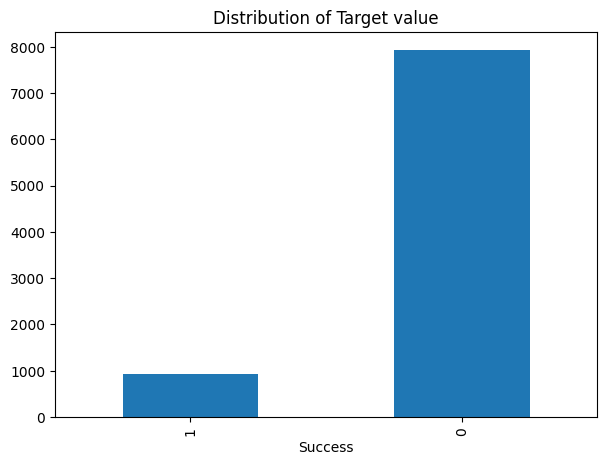

In [69]:
plt.figure(figsize = (7,5))
full_df.Success.value_counts().sort_values().plot(kind = 'bar')
plt.title('Distribution of Target value')
plt.show()

In [5]:
# Define X and y
X = full_df.drop(columns=['Success'])
y = full_df['Success']

# Split into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle = True,
                                                    test_size = 0.2,
                                                    random_state = 42,
                                                    stratify = y)
# Reset index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Scale the data
scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

## 3-0. Define Baseline Model

### Generate class for efficiency

In [84]:
class ModelEvaluator:
    def __init__(self):
        self.graph_df = pd.DataFrame(columns = ['Method', 'f1_score', 'pr_auc_score'])

    def calculate_update_score(self, model, method, selected_features, manual_X_train=None, manual_X_test=None):

        # if selected_features == 'manual' and manual_X_train is not None and manual_X_test is not None:
        if isinstance(selected_features, str) and selected_features == 'manual' and manual_X_train is not None and manual_X_test is not None:
            sel_X_train = manual_X_train
            sel_X_train = manual_X_train
            sel_X_test = manual_X_test
            num_features = manual_X_train.shape[1]
        else:
            sel_X_train = X_train_scaled[selected_features]
            sel_X_test = X_test_scaled[selected_features]
            num_features = len(selected_features)

        model.fit(sel_X_train, y_train)

        y_pred = model.predict(sel_X_test)
        y_probs = model.predict_proba(sel_X_test)[:, 1]

        f1 = round(f1_score(y_test, y_pred, average = 'weighted'), 3)
        pr_auc = round(average_precision_score(y_test, y_probs), 3)

        print(f'{method}_n_features_{num_features}_f1_score :, {f1}')
        print(f'{method}_n_features_{num_features}_pr_auc_score : {pr_auc}')

        # Append results to the graph DataFrame
        new_row = pd.DataFrame([{
            'Method' : f'{method}_n_features_{num_features}',
            # 'Method' : f'{method}',
            'f1_score' : f1,
            'pr_auc_score' : pr_auc
        }],)
        self.graph_df = pd.concat([self.graph_df, new_row], ignore_index=True)

    def plot_scores(self):
        graph_df_long = self.graph_df.melt(id_vars = 'Method', var_name = 'Metric', value_name = 'Score')

        # Dynamically adjust the figure width based on the number of methods
        fig_width = max(8, len(self.graph_df['Method'].unique()) * 2)  # Ensures a minimum width of 8
        plt.figure(figsize=(fig_width, 6))

        # Plot with seaborn
        ax = sns.barplot(x = 'Method', y = 'Score', hue = 'Metric', data = graph_df_long)
        plt.title('Comparison of F1 score and PR-AUC score by method')
        plt.ylabel('Score')
        plt.xlabel('Method')
        plt.ylim(0,1)
        ax.legend(loc = 'upper left', bbox_to_anchor=(1, 1))

        # Add values on top of each bar
        for container in ax.containers:
            ax.bar_label(container, fmt = '%.3f', padding = 3)

        plt.xticks(rotation = 45, ha = 'right')
        plt.tight_layout()
        plt.show()

In [74]:
evaluator = ModelEvaluator()

In [75]:
dt_clf = tree.DecisionTreeClassifier(random_state= 42)
evaluator.calculate_update_score(dt_clf, method = 'DecisionTree', selected_features = X.columns)
# evaluator.plot_scores()

DecisionTree_n_features_29_f1_score :, 0.851
DecisionTree_n_features_29_pr_auc_score : 0.178


<ipython-input-73-800bcd1b97d2>:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.graph_df = pd.concat([self.graph_df, new_row], ignore_index=True)


In [76]:
knn_clf = KNeighborsClassifier()
evaluator.calculate_update_score(knn_clf, method = 'KNN', selected_features = X.columns)
# evaluator.plot_scores()

KNN_n_features_29_f1_score :, 0.857
KNN_n_features_29_pr_auc_score : 0.192


In [77]:
lr_clf = LogisticRegression(solver = 'liblinear',random_state=42)
evaluator.calculate_update_score(lr_clf, method = 'Logistic_Regression', selected_features = X.columns)
# evaluator.plot_scores()

Logistic_Regression_n_features_29_f1_score :, 0.859
Logistic_Regression_n_features_29_pr_auc_score : 0.331


In [78]:
rf_clf = RandomForestClassifier(random_state=42)
evaluator.calculate_update_score(rf_clf, method = 'RF', selected_features = X.columns)
# evaluator.plot_scores()

RF_n_features_29_f1_score :, 0.87
RF_n_features_29_pr_auc_score : 0.436


In [79]:
gbm_clf = GradientBoostingClassifier(random_state=42)
evaluator.calculate_update_score(gbm_clf, method = 'GBM', selected_features = X.columns)
# evaluator.plot_scores()

GBM_n_features_29_f1_score :, 0.878
GBM_n_features_29_pr_auc_score : 0.456


In [80]:
xgb_clf = XGBClassifier(random_state=42)
evaluator.calculate_update_score(xgb_clf, method = 'XGB', selected_features = X.columns)
# evaluator.plot_scores()

XGB_n_features_29_f1_score :, 0.889
XGB_n_features_29_pr_auc_score : 0.47


In [81]:
cb_clf = CatBoostClassifier(verbose = 0, random_state = 42)
evaluator.calculate_update_score(cb_clf, method = 'CatBoost', selected_features = X.columns)
# evaluator.plot_scores()

CatBoost_n_features_29_f1_score :, 0.885
CatBoost_n_features_29_pr_auc_score : 0.468


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
LGBM_n_features_29_f1_score :, 0.883
LGBM_n_features_29_pr_auc_score : 0.443


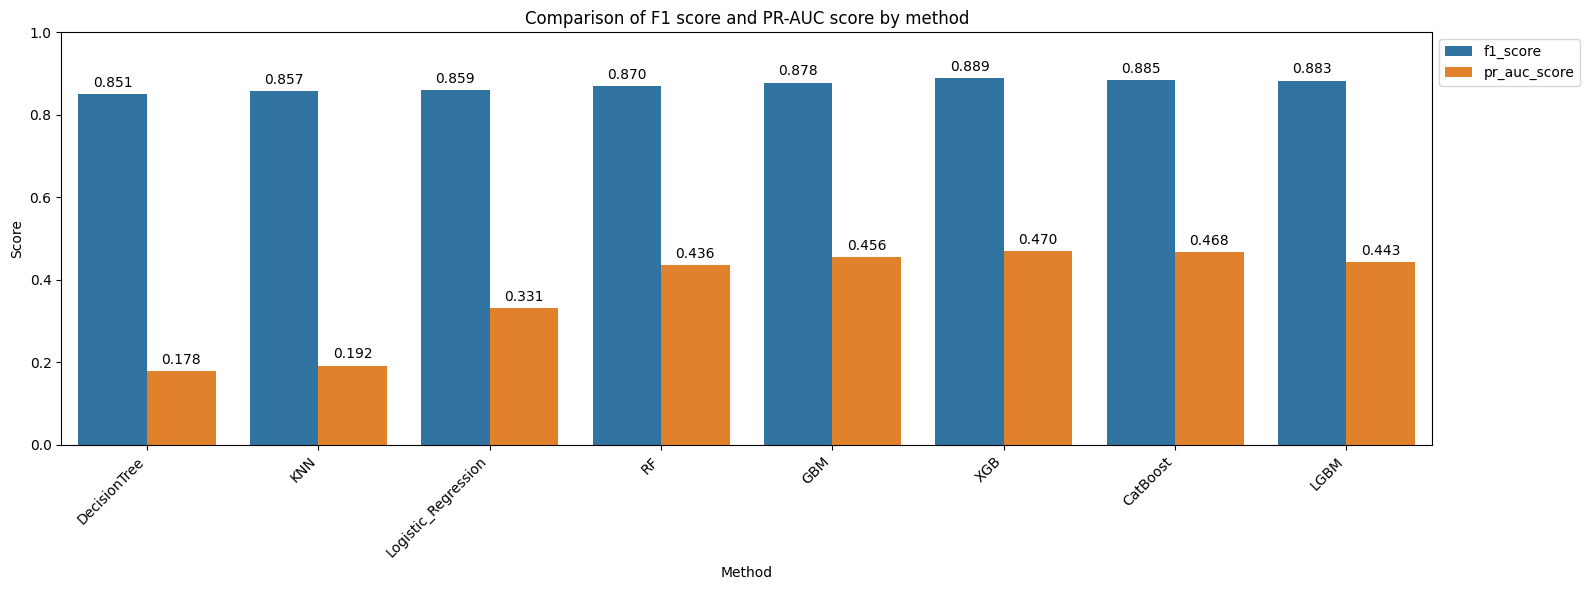

In [82]:
lgbm_clf = LGBMClassifier(random_state=42, verbose = 0)
evaluator.calculate_update_score(lgbm_clf, method = 'LGBM', selected_features = X.columns)
evaluator.plot_scores()

    I selected XGBoost as the baseline model due to its relatively high F1 and PR-AUC scores.

In [83]:
base_model = xgb_clf

## 3-1. Filter Methods -(1) Variance Threshold

In [85]:
scaler = MinMaxScaler()

X_train_scaled_minmax = scaler.fit_transform(X_train)

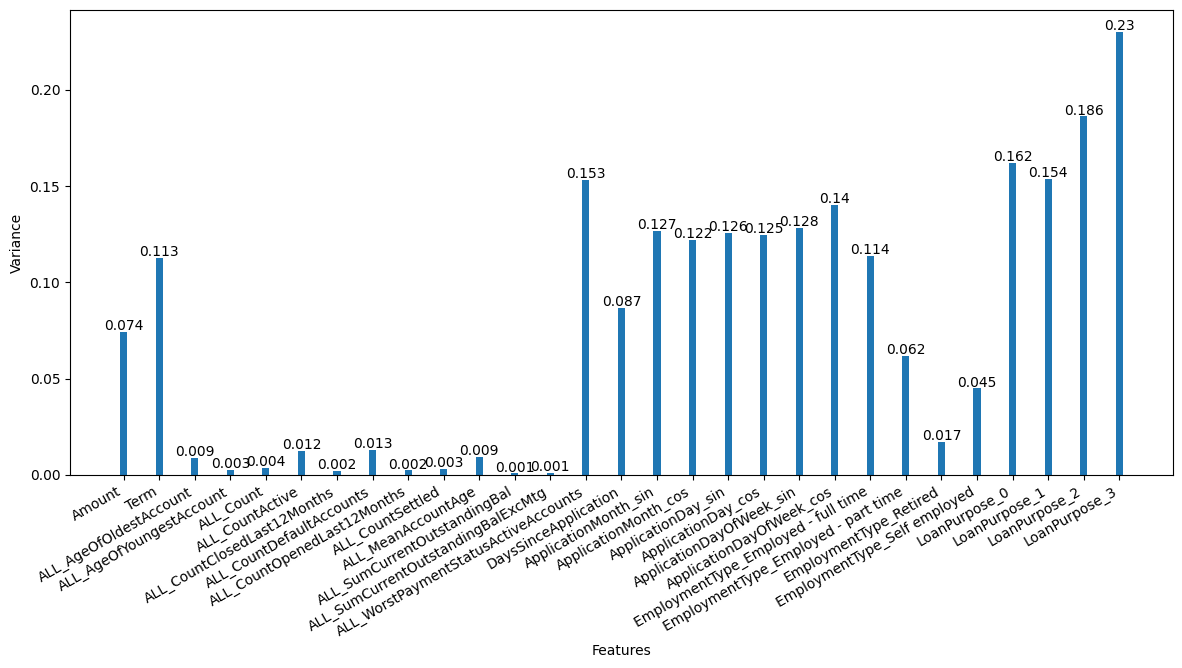

In [86]:
fig, ax = plt.subplots(figsize = (12,6))

x = X.columns
y = X_train_scaled_minmax.var(axis=0)

ax.bar(x, y, width=0.2)
ax.set_xlabel('Features')
ax.set_ylabel('Variance')
# ax.set_ylim(0, 0.1)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.001, s=str(round(value, 3)), ha='center')

plt.tight_layout()
fig.autofmt_xdate()
plt.show()

In [88]:
evaluator = ModelEvaluator()
evaluator.calculate_update_score(base_model, method = 'base_xgb', selected_features = X.columns)

base_xgb_n_features_29_f1_score :, 0.889
base_xgb_n_features_29_pr_auc_score : 0.47


<ipython-input-84-35fb3382757c>:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.graph_df = pd.concat([self.graph_df, new_row], ignore_index=True)


In [93]:
var_threshold = 0.15
# var_threshold = 0.05
var_selected_cols = X.columns[[value > var_threshold for value in X_train_scaled_minmax.var(axis=0)]]
print(var_selected_cols)

Index(['ALL_WorstPaymentStatusActiveAccounts', 'LoanPurpose_0',
       'LoanPurpose_1', 'LoanPurpose_2', 'LoanPurpose_3'],
      dtype='object')


Var_threshole_0.15_n_features_5_f1_score :, 0.847
Var_threshole_0.15_n_features_5_pr_auc_score : 0.158


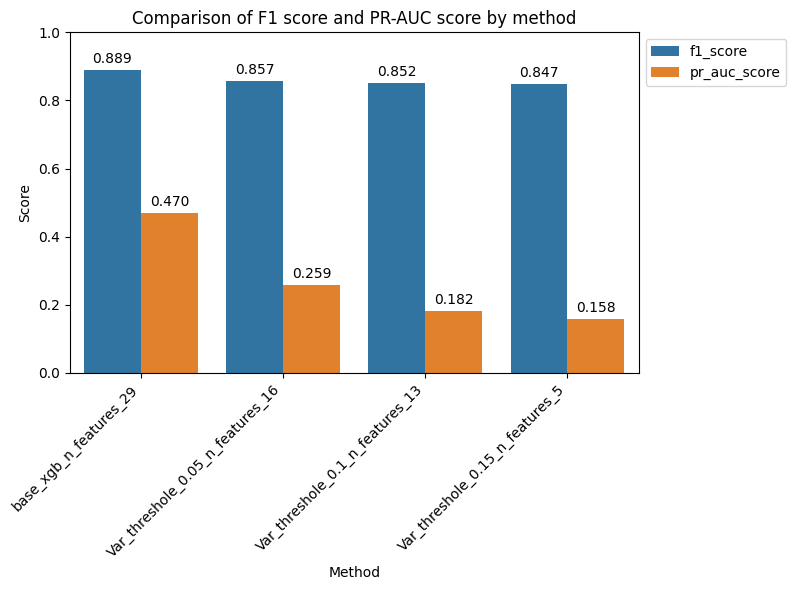

In [94]:
evaluator.calculate_update_score(base_model, method = f'Var_threshole_{var_threshold}', selected_features=var_selected_cols)
evaluator.plot_scores()

    After dropping some low-variance columns, the F1 and PR-AUC scores decreased, so I decided not to drop any columns moving forward.

## 3-1. Filter Methods - (2) Correlation

When the correlation between features exceeds 0.8, keep the one with a higher correlation to the target and drop the other. Then, keep only the top N features with the highest correlation to the target.

In [95]:
evaluator = ModelEvaluator()
evaluator.calculate_update_score(base_model, method = 'base_xgb', selected_features = X.columns)
# evaluator.plot_scores()

base_xgb_n_features_29_f1_score :, 0.889
base_xgb_n_features_29_pr_auc_score : 0.47


<ipython-input-84-35fb3382757c>:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.graph_df = pd.concat([self.graph_df, new_row], ignore_index=True)


In [96]:
# Calculate the correlation matrix using Spearman
correlation_matrix = full_df.corr(method='spearman')

# Calculate correlation of each feature with the target
target_corr = full_df.corr()['Success'].abs().drop('Success')

# Identify pairs of features with high inter-correlation
correlation_threshold = 0.8
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# For each pair of highly correlated features, drop the one with the lower correlation to the target
to_drop = set()  # Use a set to avoid duplicate entries
for column in upper_triangle.columns:
    high_corr_features = upper_triangle.index[upper_triangle[column].abs() > correlation_threshold].tolist()
    for feature in high_corr_features:
        # Compare correlation with the target and keep the more correlated feature
        if target_corr[feature] > target_corr[column]:
            to_drop.add(column)
        else:
            to_drop.add(feature)

# Drop the selected features from X_train
print(to_drop)
X_reduced = X.drop(columns=to_drop)

{'ALL_CountSettled', 'ALL_Count', 'ALL_CountDefaultAccounts'}


In [97]:
# Select top features with the highest absolute correlation to the target
n = 15  # Number of top features to keep
corr_selected_cols = target_corr.drop(index=to_drop).nlargest(n).index.tolist()

print("Selected features:", corr_selected_cols)

Selected features: ['ALL_WorstPaymentStatusActiveAccounts', 'Amount', 'ALL_MeanAccountAge', 'ALL_AgeOfOldestAccount', 'ALL_CountOpenedLast12Months', 'ALL_CountActive', 'ALL_SumCurrentOutstandingBalExcMtg', 'ALL_SumCurrentOutstandingBal', 'DaysSinceApplication', 'ALL_CountClosedLast12Months', 'ApplicationMonth_sin', 'EmploymentType_Employed - part time', 'EmploymentType_Self employed', 'ApplicationDay_sin', 'LoanPurpose_1']


In [98]:
corr_selected_cols

['ALL_WorstPaymentStatusActiveAccounts',
 'Amount',
 'ALL_MeanAccountAge',
 'ALL_AgeOfOldestAccount',
 'ALL_CountOpenedLast12Months',
 'ALL_CountActive',
 'ALL_SumCurrentOutstandingBalExcMtg',
 'ALL_SumCurrentOutstandingBal',
 'DaysSinceApplication',
 'ALL_CountClosedLast12Months',
 'ApplicationMonth_sin',
 'EmploymentType_Employed - part time',
 'EmploymentType_Self employed',
 'ApplicationDay_sin',
 'LoanPurpose_1']

- Corr_1 : For each pair of highly correlated features, drop the one with the lower correlation to the target only -> n_features = 25
- Corr_ : Corr_1 + chosse top N features in the order of highest absolute correlation to the target -> n_features = 10

Corr_1_n_features_26_f1_score :, 0.884
Corr_1_n_features_26_pr_auc_score : 0.443


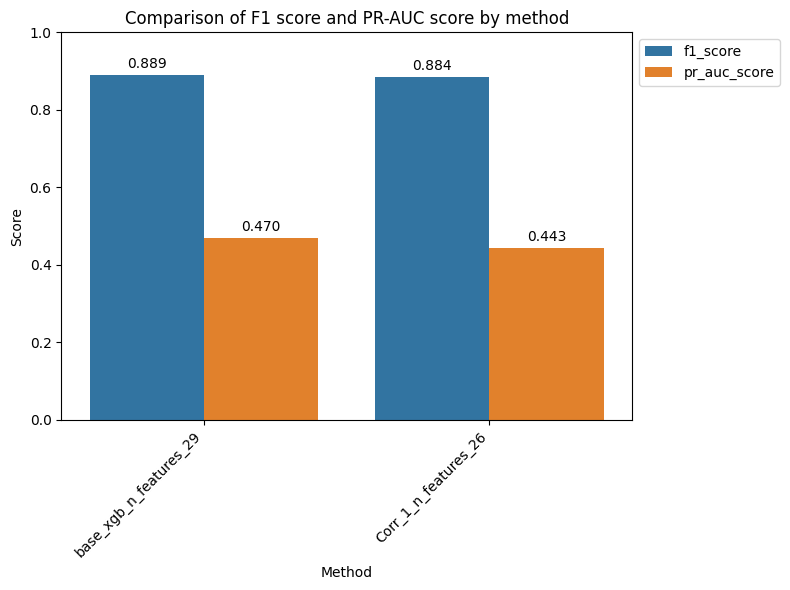

In [99]:
evaluator.calculate_update_score(base_model, method = 'Corr_1', selected_features = X_reduced.columns)
# evaluator.calculate_update_score(base_model, method = 'Corr', selected_features = corr_selected_cols)

evaluator.plot_scores()

In [100]:
def number_of_top_features(n):
    corr_selected_cols = target_corr.drop(index=to_drop).nlargest(n).index.tolist()
    evaluator.calculate_update_score(base_model, method = 'Corr', selected_features = corr_selected_cols)
    # evaluator.plot_scores()

for i in range(3,20,2):
    number_of_top_features(i)

Corr_n_features_3_f1_score :, 0.858
Corr_n_features_3_pr_auc_score : 0.288
Corr_n_features_5_f1_score :, 0.86
Corr_n_features_5_pr_auc_score : 0.309
Corr_n_features_7_f1_score :, 0.873
Corr_n_features_7_pr_auc_score : 0.366
Corr_n_features_9_f1_score :, 0.882
Corr_n_features_9_pr_auc_score : 0.439
Corr_n_features_11_f1_score :, 0.885
Corr_n_features_11_pr_auc_score : 0.418
Corr_n_features_13_f1_score :, 0.886
Corr_n_features_13_pr_auc_score : 0.436
Corr_n_features_15_f1_score :, 0.876
Corr_n_features_15_pr_auc_score : 0.412
Corr_n_features_17_f1_score :, 0.886
Corr_n_features_17_pr_auc_score : 0.446
Corr_n_features_19_f1_score :, 0.881
Corr_n_features_19_pr_auc_score : 0.436


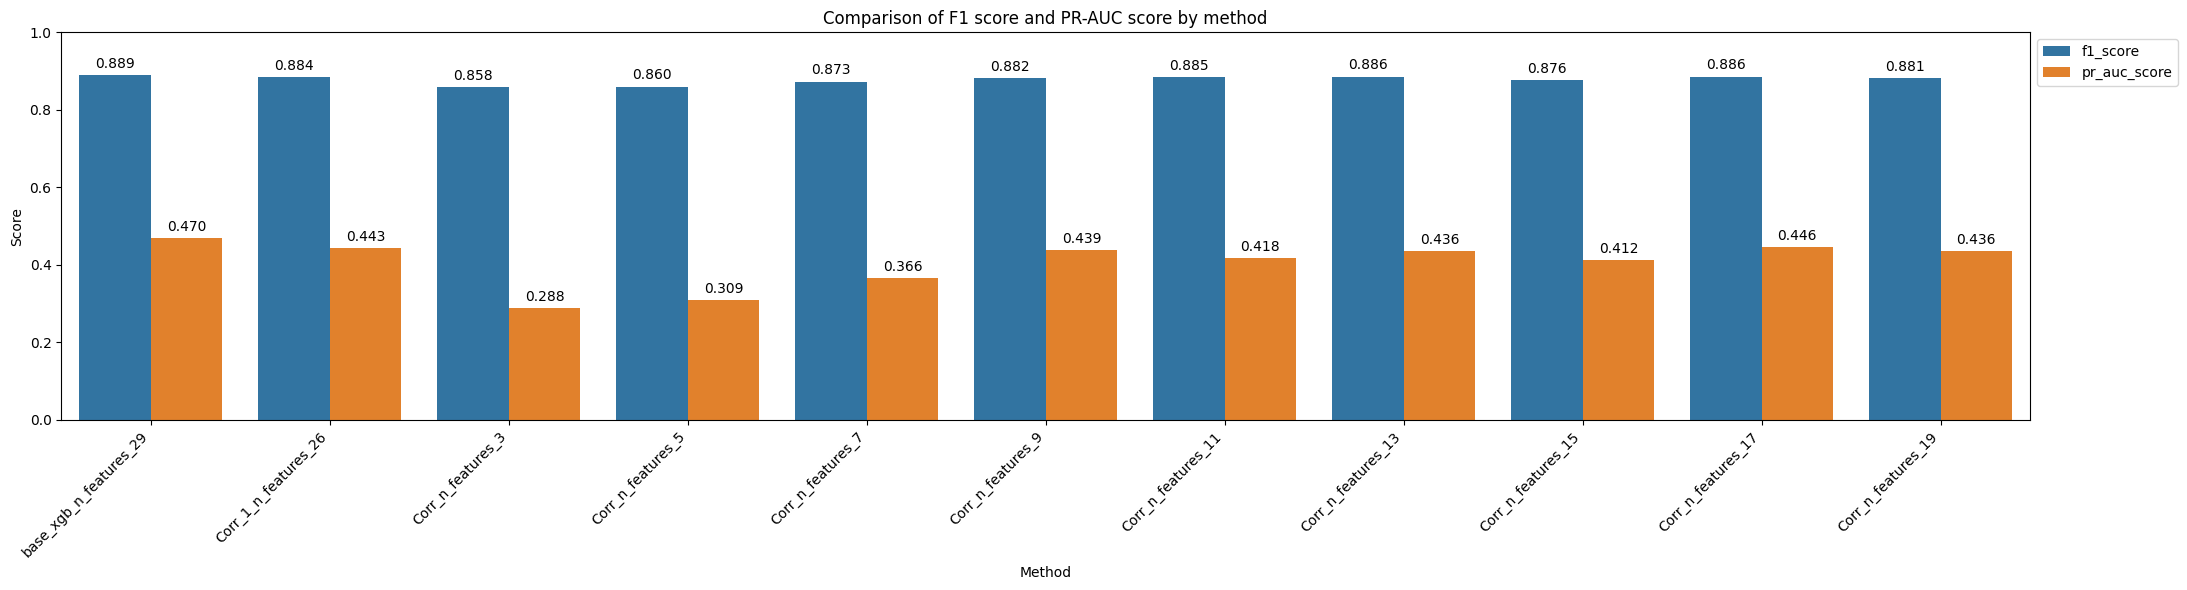

In [101]:
evaluator.plot_scores()

    We found that reducing the number of features to a very small set, like 5, leads to a low PR-AUC score. However, aside from this extreme case, the scores remain stable regardless of the number of features.

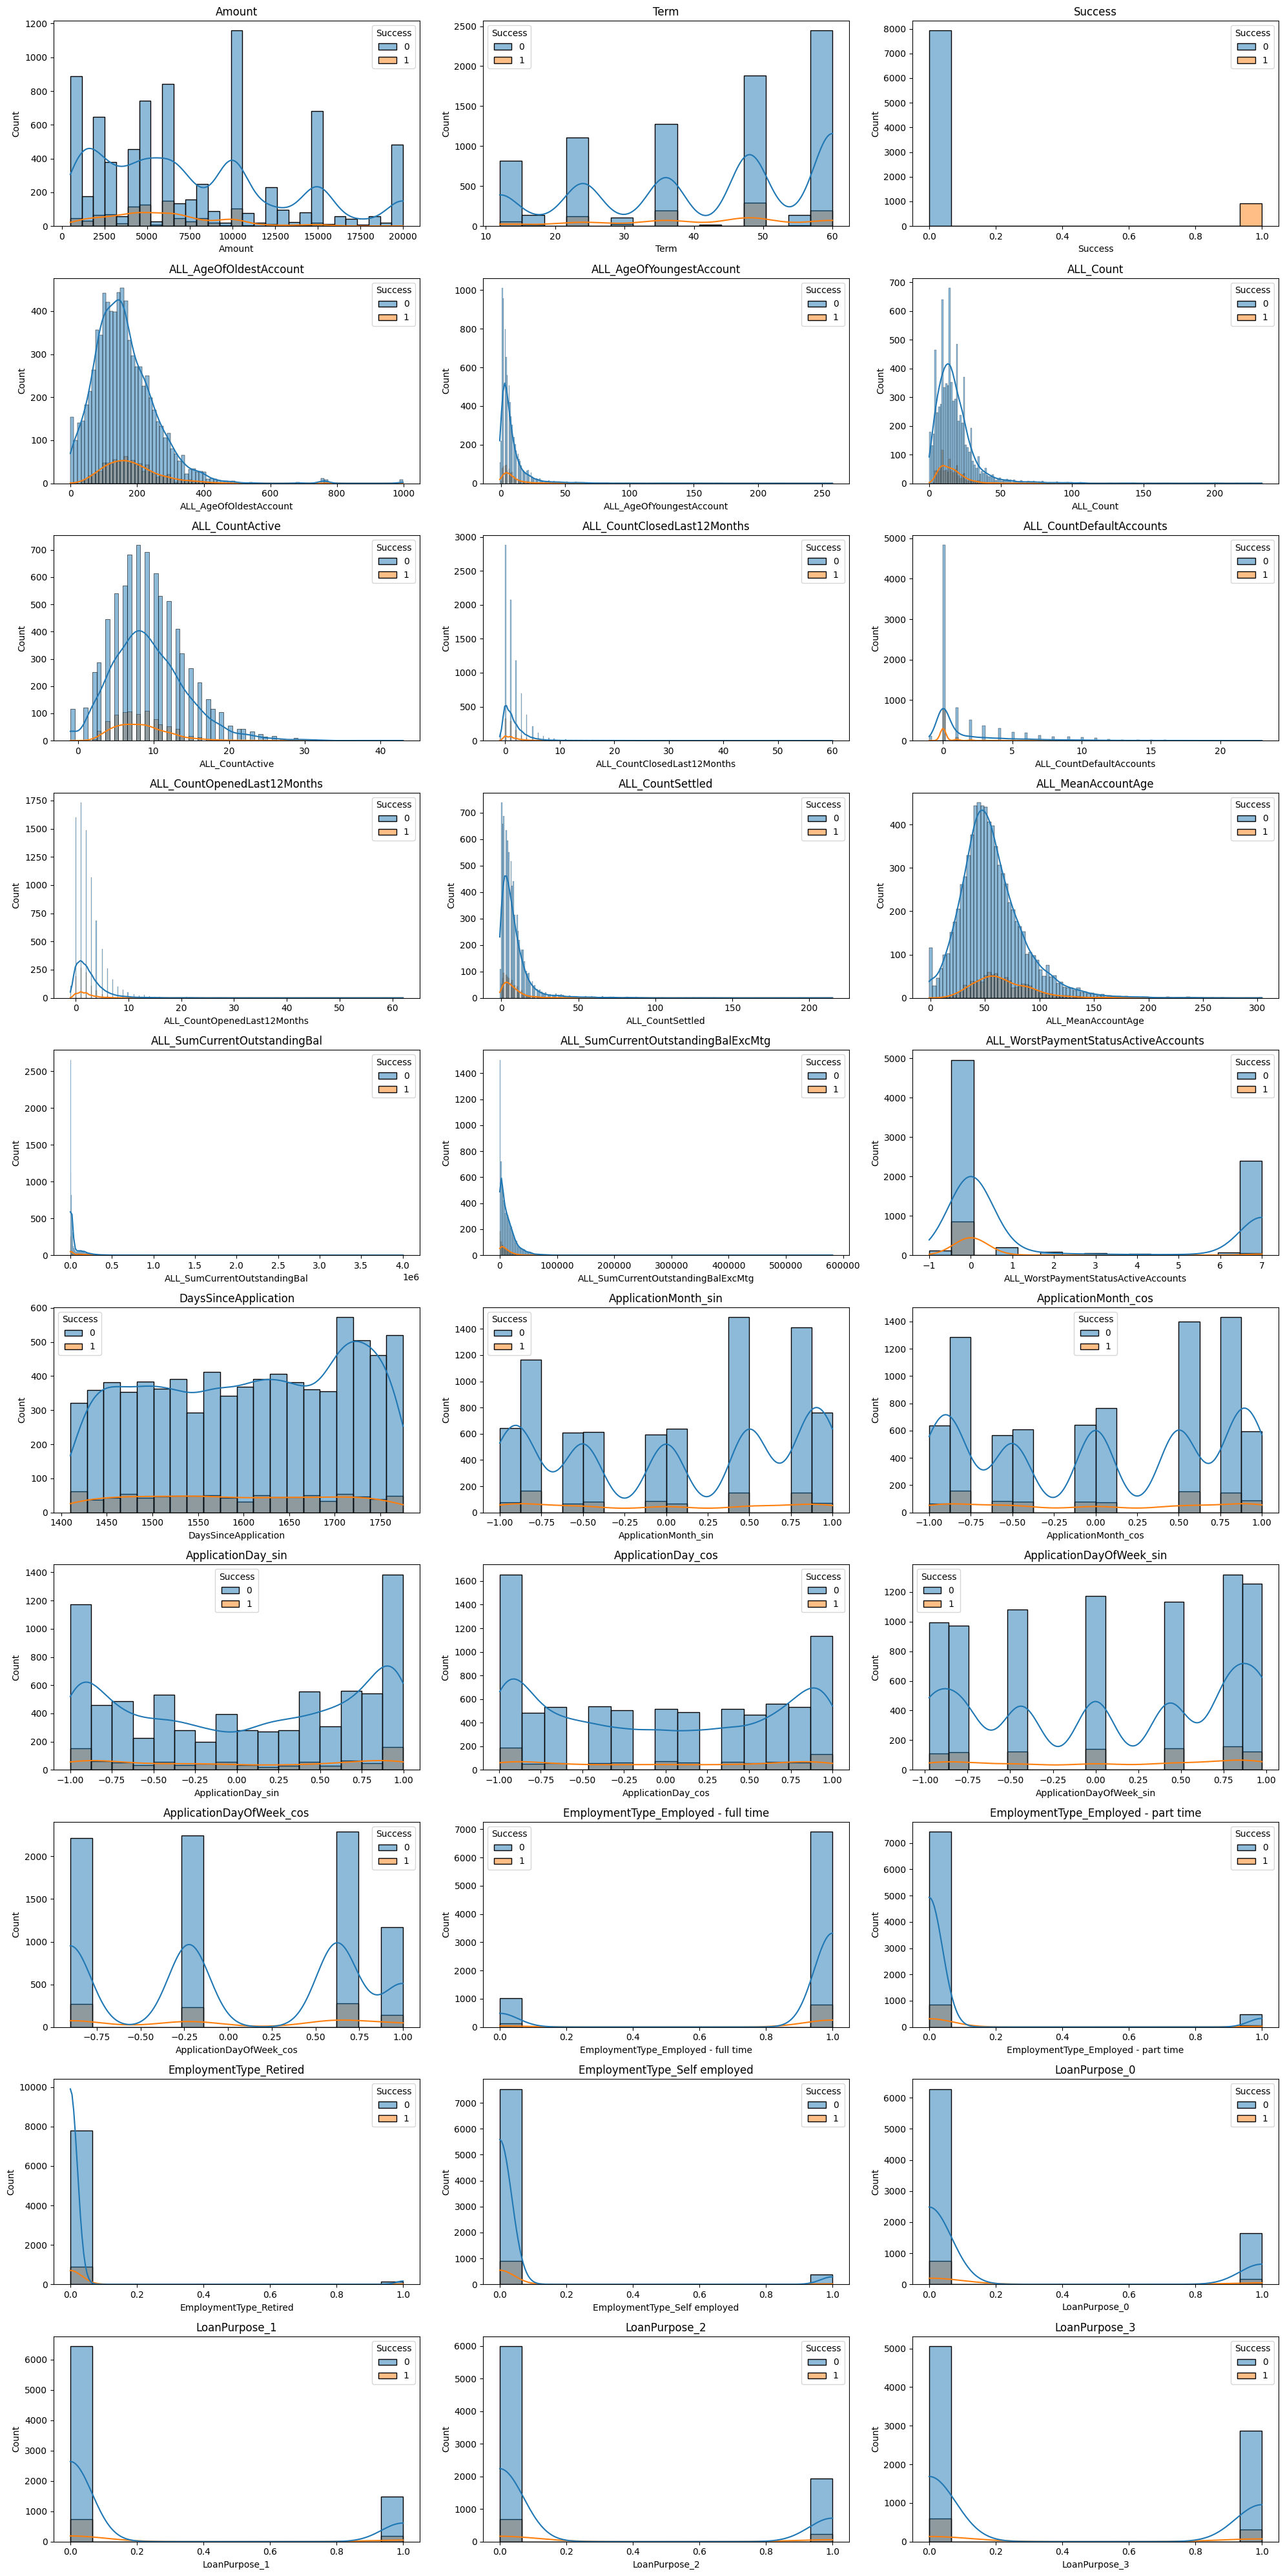

In [102]:
num_features = full_df.select_dtypes(include=['float64', 'int64']).columns

num_plots = len(num_features)
ncols = 3
nrows = (num_plots // ncols) + (num_plots % ncols > 0)

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (20, nrows * 4))
axes = axes.flatten()

for i, feature in enumerate(num_features):
    sns.histplot(data = full_df, x = feature, hue = 'Success', kde = True, ax = axes[i])
    axes[i].set_title(feature)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 3-1. Filter Method - (3) Mutual Information

In [103]:
f1_score_list = []
pr_auc_score_list = []

In [104]:
len(X.columns)

29

In [105]:
for k in range(1, len(X.columns)+1):
    selector = SelectKBest(mutual_info_classif, k = k)
    selector.fit(X_train, y_train)

    kbest_X_train = selector.transform(X_train)
    kbest_X_test = selector.transform(X_test)

    base_model.fit(kbest_X_train, y_train)
    kbest_y_pred = base_model.predict(kbest_X_test)
    kbest_y_probs = base_model.predict_proba(kbest_X_test)[:, 1]

    kbest_f1_score = round(f1_score(y_test, kbest_y_pred, average = 'weighted'), 3)
    kbest_pr_auc_score = round(average_precision_score(y_test, kbest_y_probs), 3)

    f1_score_list.append(kbest_f1_score)
    pr_auc_score_list.append(kbest_pr_auc_score)


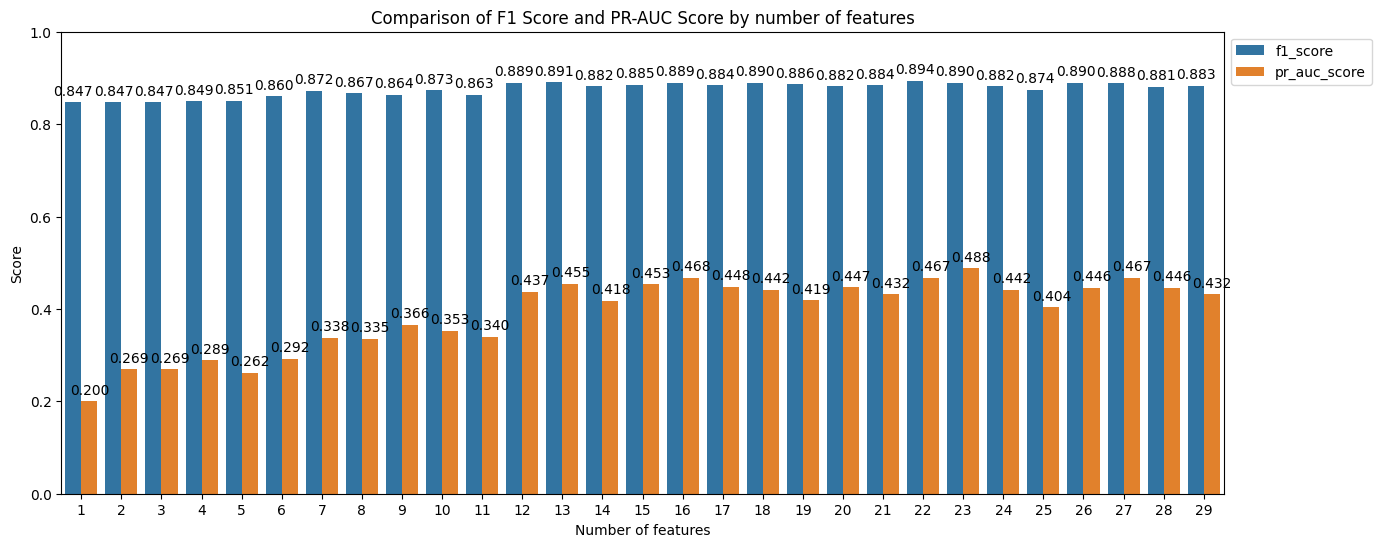

In [106]:
temp_df = pd.DataFrame({
    'number_features' : range(1,len(X.columns)+1),
    'f1_score' : f1_score_list,
    'pr_auc_score' : pr_auc_score_list
})

# Melt the DataFrame into long format
temp_df_long = temp_df.melt(id_vars='number_features', var_name='Metric', value_name='Score')

# Plot with Seaborn
plt.figure(figsize=(15, 6))
ax = sns.barplot(x='number_features', y='Score', hue='Metric', data= temp_df_long)
plt.title('Comparison of F1 Score and PR-AUC Score by number of features')
plt.ylabel('Score')
plt.xlabel('Number of features')
plt.ylim(0,1)
ax.legend(loc = 'upper left', bbox_to_anchor=(1, 1))

# Add values on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3)

plt.show()

In [107]:
evaluator = ModelEvaluator()
evaluator.calculate_update_score(base_model, method = 'base_xgb', selected_features = X.columns)

base_xgb_n_features_29_f1_score :, 0.889
base_xgb_n_features_29_pr_auc_score : 0.47


<ipython-input-84-35fb3382757c>:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.graph_df = pd.concat([self.graph_df, new_row], ignore_index=True)


In [114]:
selector = SelectKBest(mutual_info_classif, k = 5)
selector.fit(X_train, y_train)

selected_feature_mask = selector.get_support()

mi_sel_features = X_train.columns[selected_feature_mask]

mi_sel_features

Index(['Amount', 'ALL_Count', 'ALL_CountActive', 'ALL_CountDefaultAccounts',
       'ALL_WorstPaymentStatusActiveAccounts'],
      dtype='object')

Filter_MI_n_features_5_f1_score :, 0.855
Filter_MI_n_features_5_pr_auc_score : 0.291


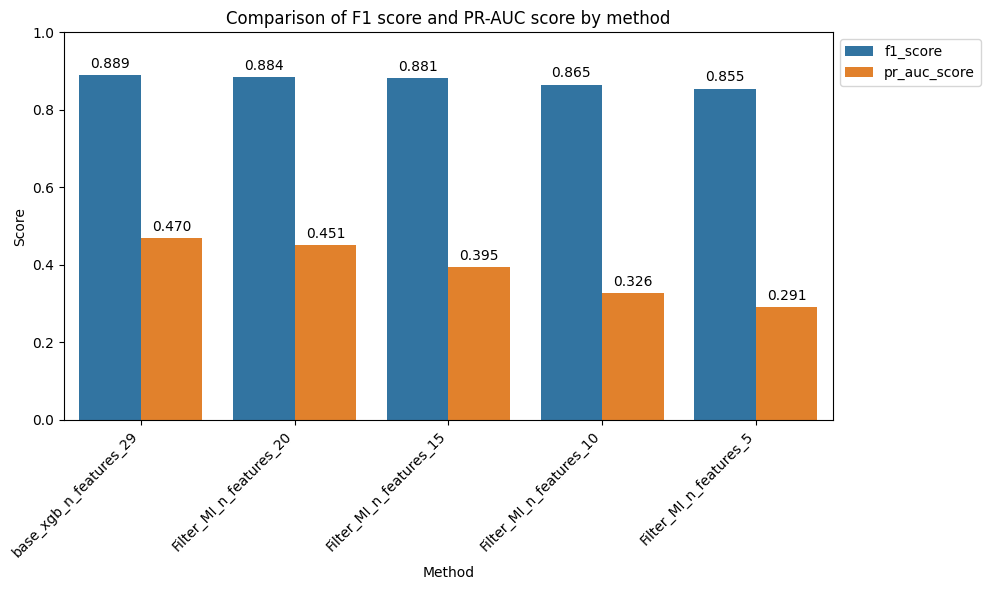

In [115]:
evaluator.calculate_update_score(base_model, method = 'Filter_MI', selected_features = mi_sel_features)
evaluator.plot_scores()

    Similarly, when the feature count drops below certain number, the PR-AUC score begins to decrease. Therefore, it’s preferable to keep around 20 features for optimal performance.

## 3-2. Wrapper Methods - Recursive feature Elimination (RFE)

In [116]:
# Define cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Custom scorers for weighted F1 and PR-AUC
weighted_f1_scorer = make_scorer(f1_score, average='weighted')
pr_auc_scorer = make_scorer(average_precision_score, needs_proba=True)

# Use RFECV to perform RFE with cross-validation
# We specify 'f1' as the scoring to optimize F1-score during feature selection
selector = RFECV(estimator=base_model, step=1, cv=cv_strategy, scoring = weighted_f1_scorer, min_features_to_select=5)
selector.fit(X_train_scaled, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


RFECV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
      estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,...
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...),
      min_features_to_select=5,
      scoring=make_scorer(f1_score, response_method='predict', average=weighted))

In [117]:
# Print selected feature names
selected_features = X_train.columns[selector.support_]
optimal_n_features = selector.n_features_
optimal_score = max(selector.cv_results_['mean_test_score'])
print("Optimal number of features : ", optimal_n_features)
print("Selected Features:", selected_features.to_list())
print("Cross-validated Weighted F1 Score at optimal features", round(optimal_score,2))

Optimal number of features :  29
Selected Features: ['Amount', 'Term', 'ALL_AgeOfOldestAccount', 'ALL_AgeOfYoungestAccount', 'ALL_Count', 'ALL_CountActive', 'ALL_CountClosedLast12Months', 'ALL_CountDefaultAccounts', 'ALL_CountOpenedLast12Months', 'ALL_CountSettled', 'ALL_MeanAccountAge', 'ALL_SumCurrentOutstandingBal', 'ALL_SumCurrentOutstandingBalExcMtg', 'ALL_WorstPaymentStatusActiveAccounts', 'DaysSinceApplication', 'ApplicationMonth_sin', 'ApplicationMonth_cos', 'ApplicationDay_sin', 'ApplicationDay_cos', 'ApplicationDayOfWeek_sin', 'ApplicationDayOfWeek_cos', 'EmploymentType_Employed - full time', 'EmploymentType_Employed - part time', 'EmploymentType_Retired', 'EmploymentType_Self employed', 'LoanPurpose_0', 'LoanPurpose_1', 'LoanPurpose_2', 'LoanPurpose_3']
Cross-validated Weighted F1 Score at optimal features 0.88


In [118]:
##############################################################
# Transform X to keep only the selected features
X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)

# Re-fit the model on the training set with selected features
base_model.fit(X_train_selected, y_train)

# Predict probabilities on the test set to adjust the threshold
y_probs = base_model.predict_proba(X_test_selected)[:, 1]
y_pred = base_model.predict(X_test_selected)

# Try different thresholds to optimize F1 score
f1 = f1_score(y_test, y_pred, average= 'weighted')
pr_auc = average_precision_score(y_test, y_probs)
rfe_pr_auc = pr_auc

print("Weighted F1 score with selected features:", round(f1,3))
print("PR-AUC with selected features:", round(pr_auc,3))

Weighted F1 score with selected features: 0.889
PR-AUC with selected features: 0.47


In [119]:
evaluator = ModelEvaluator()
evaluator.calculate_update_score(base_model, method = 'base_xgb', selected_features = X.columns)

base_xgb_n_features_29_f1_score :, 0.889
base_xgb_n_features_29_pr_auc_score : 0.47


<ipython-input-84-35fb3382757c>:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.graph_df = pd.concat([self.graph_df, new_row], ignore_index=True)


In [120]:
# evaluator.calculate_update_score(base_model, method = 'Wrapper_RFE', selected_features = selected_features)
# evaluator.plot_scores()

    - It gives us all the 29 featrues

## 3-3. Embedded Methods

### Lasso

In [121]:
param_dist = {'C': loguniform(0.001, 1)}
feature_names = X.columns

model = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, scoring=weighted_f1_scorer, cv=cv, n_iter=10, random_state=42)
random_search.fit(X_train_scaled, y_train)

# Get the best C value and F1 score
best_C = random_search.best_params_['C']
best_score = random_search.best_score_
print(f"Best C from Random Search: {best_C}")
print(f"Best Weighted F1 Score from Random Search: {best_score:.3f}")

# Check the number of selected features
best_model = random_search.best_estimator_
num_selected_features = np.sum(best_model.coef_[0] != 0)
print(f"Number of selected features with best C: {num_selected_features}")
lasso_coefficients = best_model.coef_[0]
selected_features_lasso = [feature_names[i] for i, coef in enumerate(lasso_coefficients) if coef != 0]
print("Selected features by Lasso:", selected_features_lasso)

Best C from Random Search: 0.711447600934342
Best Weighted F1 Score from Random Search: 0.854
Number of selected features with best C: 23
Selected features by Lasso: ['Amount', 'Term', 'ALL_AgeOfOldestAccount', 'ALL_AgeOfYoungestAccount', 'ALL_CountActive', 'ALL_CountDefaultAccounts', 'ALL_CountOpenedLast12Months', 'ALL_CountSettled', 'ALL_MeanAccountAge', 'ALL_SumCurrentOutstandingBal', 'ALL_SumCurrentOutstandingBalExcMtg', 'ALL_WorstPaymentStatusActiveAccounts', 'DaysSinceApplication', 'ApplicationMonth_sin', 'ApplicationMonth_cos', 'ApplicationDay_sin', 'ApplicationDay_cos', 'ApplicationDayOfWeek_sin', 'EmploymentType_Employed - full time', 'EmploymentType_Retired', 'EmploymentType_Self employed', 'LoanPurpose_0', 'LoanPurpose_2']


    This method resulted in 23 features, with an F1 score slightly lower than our previous model.

### Feature Importances

In [127]:
evaluator = ModelEvaluator()
evaluator.calculate_update_score(base_model, method = 'base_xgb', selected_features = X.columns)

base_xgb_n_features_29_f1_score :, 0.889
base_xgb_n_features_29_pr_auc_score : 0.47


<ipython-input-84-35fb3382757c>:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.graph_df = pd.concat([self.graph_df, new_row], ignore_index=True)


In [124]:
# Set up the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

feature_importances = []

# For each fold, train the model and extract feature importance
for train_idx, val_idx in cv.split(X_train_scaled, y_train):

    # Split training and validation data
    X_fold_train, X_fold_val = X_train_scaled.iloc[train_idx], X_train_scaled.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train the model
    base_model.fit(X_fold_train, y_fold_train)

    # Store feature importances from this fold
    feature_importances.append(base_model.feature_importances_)

# Calculate the mean feature importance across all folds
mean_importances = np.mean(feature_importances, axis=0)

# Organize feature importances into a DataFrame for better readability
feature_names = X.columns.to_list()
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': mean_importances})

# Custom scorer
weighted_f1_scorer = make_scorer(f1_score, average='weighted')
pr_auc_scorer = make_scorer(average_precision_score, needs_proba=True)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


In [125]:
#  Select the top N features
top_n = 30
selected_features_top_n = feature_importances_df.sort_values(by='Importance', ascending=False).head(top_n)
top_n_features = selected_features_top_n['Feature'].values
print("Top N Features:\n", selected_features_top_n)

Top N Features:
                                  Feature  Importance
13  ALL_WorstPaymentStatusActiveAccounts    0.225174
0                                 Amount    0.062030
7               ALL_CountDefaultAccounts    0.045494
12    ALL_SumCurrentOutstandingBalExcMtg    0.038811
10                    ALL_MeanAccountAge    0.037564
5                        ALL_CountActive    0.035267
22   EmploymentType_Employed - part time    0.035060
21   EmploymentType_Employed - full time    0.034677
11          ALL_SumCurrentOutstandingBal    0.033717
8            ALL_CountOpenedLast12Months    0.031395
4                              ALL_Count    0.029006
25                         LoanPurpose_0    0.025716
27                         LoanPurpose_2    0.024450
2                 ALL_AgeOfOldestAccount    0.023593
16                  ApplicationMonth_cos    0.023226
17                    ApplicationDay_sin    0.022876
6            ALL_CountClosedLast12Months    0.022317
3               ALL_AgeOfYoun

FeatureImportance_n_features_3_f1_score :, 0.847
FeatureImportance_n_features_3_pr_auc_score : 0.269
FeatureImportance_n_features_4_f1_score :, 0.858
FeatureImportance_n_features_4_pr_auc_score : 0.276
FeatureImportance_n_features_5_f1_score :, 0.872
FeatureImportance_n_features_5_pr_auc_score : 0.345
FeatureImportance_n_features_6_f1_score :, 0.879
FeatureImportance_n_features_6_pr_auc_score : 0.381
FeatureImportance_n_features_7_f1_score :, 0.874
FeatureImportance_n_features_7_pr_auc_score : 0.364
FeatureImportance_n_features_8_f1_score :, 0.881
FeatureImportance_n_features_8_pr_auc_score : 0.4
FeatureImportance_n_features_9_f1_score :, 0.875
FeatureImportance_n_features_9_pr_auc_score : 0.389
FeatureImportance_n_features_10_f1_score :, 0.888
FeatureImportance_n_features_10_pr_auc_score : 0.452
FeatureImportance_n_features_11_f1_score :, 0.885
FeatureImportance_n_features_11_pr_auc_score : 0.423
FeatureImportance_n_features_12_f1_score :, 0.887
FeatureImportance_n_features_12_pr_auc_

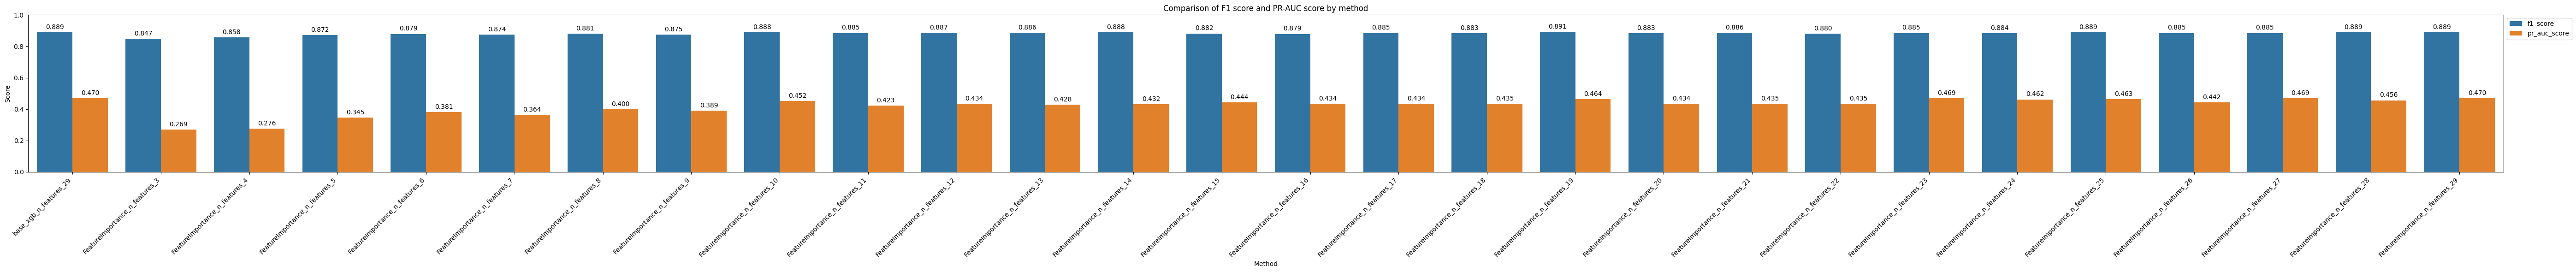

In [128]:
def number_of_top_features_fi(n):
    selected_features_top_n = feature_importances_df.sort_values(by='Importance', ascending=False).head(n)
    evaluator.calculate_update_score(base_model, method = 'FeatureImportance', selected_features = selected_features_top_n['Feature'].values)
    # evaluator.plot_scores()

for i in range(3,30):
    number_of_top_features_fi(i)

evaluator.plot_scores()

In [129]:
top_n = 10
selected_features_top_n = feature_importances_df.sort_values(by='Importance', ascending=False).head(top_n)
fi_top_n_features = selected_features_top_n['Feature'].values
print(fi_top_n_features)
# It means those features are really important

['ALL_WorstPaymentStatusActiveAccounts' 'Amount'
 'ALL_CountDefaultAccounts' 'ALL_SumCurrentOutstandingBalExcMtg'
 'ALL_MeanAccountAge' 'ALL_CountActive'
 'EmploymentType_Employed - part time'
 'EmploymentType_Employed - full time' 'ALL_SumCurrentOutstandingBal'
 'ALL_CountOpenedLast12Months']


In [130]:
top_n = 15
selected_features_top_n = feature_importances_df.sort_values(by='Importance', ascending=False).head(top_n)
fi_top_n_features = selected_features_top_n['Feature'].values
print(fi_top_n_features)

['ALL_WorstPaymentStatusActiveAccounts' 'Amount'
 'ALL_CountDefaultAccounts' 'ALL_SumCurrentOutstandingBalExcMtg'
 'ALL_MeanAccountAge' 'ALL_CountActive'
 'EmploymentType_Employed - part time'
 'EmploymentType_Employed - full time' 'ALL_SumCurrentOutstandingBal'
 'ALL_CountOpenedLast12Months' 'ALL_Count' 'LoanPurpose_0' 'LoanPurpose_2'
 'ALL_AgeOfOldestAccount' 'ApplicationMonth_cos']


In [146]:
top_n = 20
selected_features_top_n = feature_importances_df.sort_values(by='Importance', ascending=False).head(top_n)
fi_top_n_features = selected_features_top_n['Feature'].values
print(fi_top_n_features)

['ALL_WorstPaymentStatusActiveAccounts' 'Amount'
 'ALL_CountDefaultAccounts' 'ALL_SumCurrentOutstandingBalExcMtg'
 'ALL_MeanAccountAge' 'ALL_CountActive'
 'EmploymentType_Employed - part time'
 'EmploymentType_Employed - full time' 'ALL_SumCurrentOutstandingBal'
 'ALL_CountOpenedLast12Months' 'ALL_Count' 'LoanPurpose_0' 'LoanPurpose_2'
 'ALL_AgeOfOldestAccount' 'ApplicationMonth_cos' 'ApplicationDay_sin'
 'ALL_CountClosedLast12Months' 'ALL_AgeOfYoungestAccount'
 'DaysSinceApplication' 'ApplicationDay_cos']


    we still get good scores even though the number of feature drops to around 10.
It is because the filter method typically ranks features based on individual correlation or statistical properties, which might not capture interactions between features as effectively. In contrast, the feature importance method considers each feature’s contribution within the trained model, which can highlight a smaller, highly predictive subset of features.
Also since we do have lots of one-hot encoded features, they often don’t rank highly in mehods like correlation and mutual information.

## 3-4. PCA (Dimentionality Reduction)

In [132]:
evaluator = ModelEvaluator()
evaluator.calculate_update_score(base_model, method = 'base_xgb', selected_features = X.columns)

base_xgb_n_features_29_f1_score :, 0.889
base_xgb_n_features_29_pr_auc_score : 0.47


<ipython-input-84-35fb3382757c>:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.graph_df = pd.concat([self.graph_df, new_row], ignore_index=True)


In [137]:
pca = PCA(n_components=15)
pca_X_train = pca.fit_transform(X_train_scaled)
pca_X_test = pca.transform(X_test_scaled)

PCA_n_features_15_f1_score :, 0.864
PCA_n_features_15_pr_auc_score : 0.271


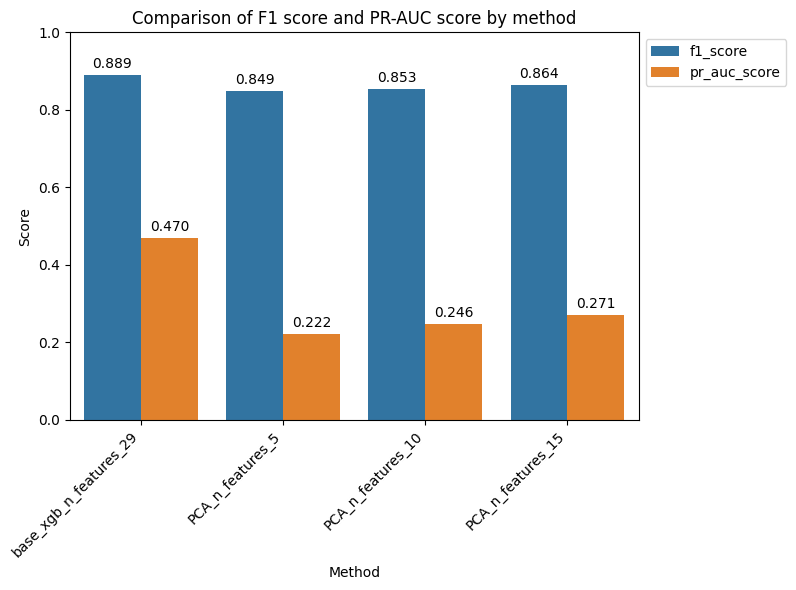

In [138]:
evaluator.calculate_update_score(base_model, method = 'PCA', selected_features = 'manual', manual_X_train= pca_X_train, manual_X_test=pca_X_test)
evaluator.plot_scores()

    For PCA, as we reduced the dimensionality, both the F1 and PR-AUC scores progressively decreased. Therefore, we decided not to consider this approach for this time.

# 4. Modeling & Evaluation

We have three main objectives:

	1.	Improve performance by tuning hyperparameters while keeping all features intact.
	2.	Reduce the number of features to lower model complexity, aiming to achieve similar or better performance.
	3.	Reduce the number of features and tune hyperparameters to achieve similar or better performance.

And we will check them step by step  
	1.	base model itself.  
	2.	base model + selected features.  
	3.	hyper param tuned model + selected features.  

In [3]:
def evaluate_model(model, x_test, y_test, desired_precision):
    # Predict test data
    y_pred = model.predict(x_test)
    y_probs = model.predict_proba(x_test)[:, 1]

    # Calculate metrics
    acc = round(accuracy_score(y_test, y_pred),3)
    prec = round(precision_score(y_test, y_pred),3)
    rec = round(recall_score(y_test, y_pred),3)
    f1 = round(f1_score(y_test, y_pred, average='weighted'), 3)
    pr_auc = round(average_precision_score(y_test, y_probs), 3)

    # Display Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
    clf_report = clf_report.round(3)

    # Precision-Recall curve and threshold adjustment
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
    selected_threshold = None
    for p, r, t in zip(precision, recall, thresholds):
        if p >= desired_precision:
            selected_threshold = t
            y_pred_adjusted = (y_probs >= selected_threshold).astype(int)

            # Calculate precision and recall at the adjusted threshold
            precision_adj = precision_score(y_test, y_pred_adjusted)
            recall_adj = recall_score(y_test, y_pred_adjusted)

            print(f"Threshold: {t:.2f}, Precision: {p:.2f}, Recall: {r:.2f}")
            print(f"Adjusted Precision: {precision_adj:.2f}, Adjusted Recall: {recall_adj:.2f}")
            break

    # Plot the Precision-Recall curve
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, marker='.', label='PR Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid()
    plt.show()

    # Print final metrics
    print('F1 Score:', f1)
    print('PR-AUC Score:', pr_auc)
    print('Accuracy:', acc)
    print('Precision:', prec)
    print('Recall:', rec)
    print('--------------------------------')
    print('Confusion Matrix:\n', cm)
    print('--------------------------------')
    print('Classification Report:\n', clf_report)

Correlation -> 15 features

['ALL_WorstPaymentStatusActiveAccounts',
 'Amount',
 'ALL_MeanAccountAge',
 'ALL_AgeOfOldestAccount',
 'ALL_CountOpenedLast12Months',
 'ALL_CountActive',
 'ALL_SumCurrentOutstandingBalExcMtg',
 'ALL_SumCurrentOutstandingBal',
 'DaysSinceApplication',
 'ALL_CountClosedLast12Months',
 'ApplicationMonth_sin',
 'EmploymentType_Employed - part time',
 'EmploymentType_Self employed',
 'ApplicationDay_sin',
 'LoanPurpose_1']

RFE -> ALL

Feature Importance 20 (Orderly)
['ALL_WorstPaymentStatusActiveAccounts' 'Amount'
 'ALL_CountDefaultAccounts' 'ALL_SumCurrentOutstandingBalExcMtg'
 'ALL_MeanAccountAge' 'ALL_CountActive'
 'EmploymentType_Employed - part time'
 'EmploymentType_Employed - full time' 'ALL_SumCurrentOutstandingBal'
 'ALL_CountOpenedLast12Months' 'ALL_Count' 'LoanPurpose_0' 'LoanPurpose_2'
 'ALL_AgeOfOldestAccount' 'ApplicationMonth_cos' 'ApplicationDay_sin'
 'ALL_CountClosedLast12Months' 'ALL_AgeOfYoungestAccount'
 'DaysSinceApplication' 'ApplicationDay_cos']

    Final Selected Features: ['ALL_WorstPaymentStatusActiveAccounts','Amount','ALL_CountDefaultAccounts','ALL_SumCurrentOutstandingBalExcMtg','ALL_MeanAccountAge','ALL_CountActive','EmploymentType_Employed - part time','EmploymentType_Employed - full time']

In [4]:
final_selected_cols = ['ALL_WorstPaymentStatusActiveAccounts','Amount','ALL_CountDefaultAccounts','ALL_SumCurrentOutstandingBalExcMtg','ALL_MeanAccountAge','ALL_CountActive','EmploymentType_Employed - part time','EmploymentType_Employed - full time']

### Decision Tree

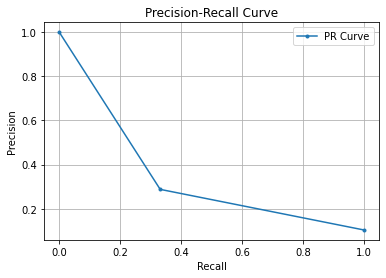

F1 Score: 0.85
PR-AUC Score: 0.165
Accuracy: 0.845
Precision: 0.288
Recall: 0.332
--------------------------------
Confusion Matrix:
 [[1435  151]
 [ 123   61]]
--------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.921   0.905     0.913  1586.000
1                 0.288   0.332     0.308   184.000
accuracy          0.845   0.845     0.845     0.845
macro avg         0.604   0.618     0.610  1770.000
weighted avg      0.855   0.845     0.850  1770.000


In [6]:
# Decision Tree
dt_clf = tree.DecisionTreeClassifier(random_state= 42)
dt_clf.fit(X_train, y_train)

# Evaluate model
evaluate_model(dt_clf, X_test, y_test, 0.8)

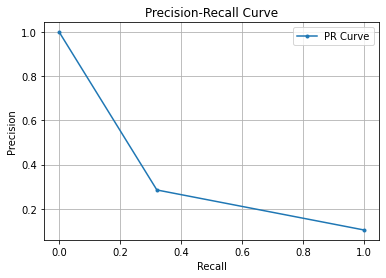

F1 Score: 0.85
PR-AUC Score: 0.162
Accuracy: 0.846
Precision: 0.285
Recall: 0.321
--------------------------------
Confusion Matrix:
 [[1438  148]
 [ 125   59]]
--------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.920   0.907     0.913  1586.000
1                 0.285   0.321     0.302   184.000
accuracy          0.846   0.846     0.846     0.846
macro avg         0.603   0.614     0.608  1770.000
weighted avg      0.854   0.846     0.850  1770.000


In [7]:
# Decision Tree
dt_clf = tree.DecisionTreeClassifier(random_state= 42)
dt_clf.fit(X_train[final_selected_cols], y_train)

# Evaluate model
evaluate_model(dt_clf, X_test[final_selected_cols], y_test, 0.8)

In [11]:
# Decision Tree
dt_clf = tree.DecisionTreeClassifier(random_state= 42)
param_distributions = {'max_depth' : randint(3,10),
                       'min_samples_split' : randint(2,20),
                       'min_samples_leaf' : randint(1,10)}

dt_clf_cv = RandomizedSearchCV(dt_clf, param_distributions, n_iter = 100, scoring = 'average_precision', cv = 5, random_state = 42, n_jobs =1)
dt_clf_cv.fit(X_train[final_selected_cols], y_train)


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7e555d8790>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7e55a2bc50>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7e55683710>},
                   random_state=42, scoring='average_precision')

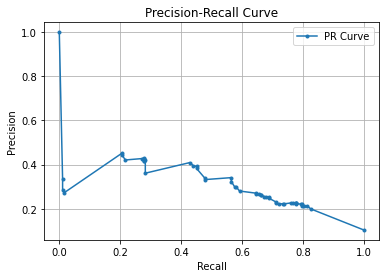

F1 Score: 0.871
PR-AUC Score: 0.313
Accuracy: 0.888
Precision: 0.421
Recall: 0.217
--------------------------------
Confusion Matrix:
 [[1531   55]
 [ 144   40]]
--------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.914   0.965     0.939  1586.000
1                 0.421   0.217     0.287   184.000
accuracy          0.888   0.888     0.888     0.888
macro avg         0.668   0.591     0.613  1770.000
weighted avg      0.863   0.888     0.871  1770.000


In [12]:
# Evaluate model
evaluate_model(dt_clf_cv, X_test[final_selected_cols], y_test, 0.8)

### Random Forest

Threshold: 0.52, Precision: 0.83, Recall: 0.11
Adjusted Precision: 0.83, Adjusted Recall: 0.11


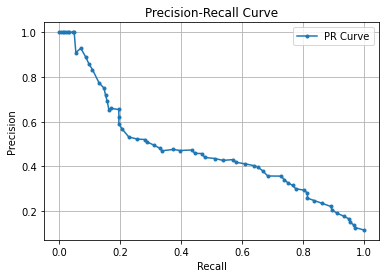

F1 Score: 0.874
PR-AUC Score: 0.464
Accuracy: 0.906
Precision: 0.774
Recall: 0.13
--------------------------------
Confusion Matrix:
 [[1579    7]
 [ 160   24]]
--------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.908   0.996     0.950  1586.000
1                 0.774   0.130     0.223   184.000
accuracy          0.906   0.906     0.906     0.906
macro avg         0.841   0.563     0.587  1770.000
weighted avg      0.894   0.906     0.874  1770.000


In [ ]:
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)

# Evaluate Model
evaluate_model(rf_clf, X_test, y_test, 0.8)

Threshold: 0.78, Precision: 0.88, Recall: 0.04
Adjusted Precision: 0.88, Adjusted Recall: 0.04


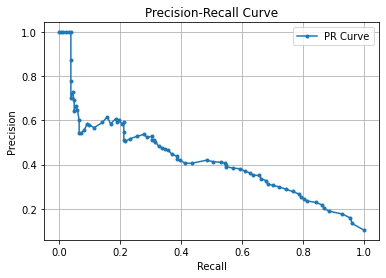

F1 Score: 0.88
PR-AUC Score: 0.413
Accuracy: 0.9
Precision: 0.549
Recall: 0.212
--------------------------------
Confusion Matrix:
 [[1554   32]
 [ 145   39]]
--------------------------------
Classification Report:
               precision  recall  f1-score  support
0                 0.915   0.980     0.946   1586.0
1                 0.549   0.212     0.306    184.0
accuracy          0.900   0.900     0.900      0.9
macro avg         0.732   0.596     0.626   1770.0
weighted avg      0.877   0.900     0.880   1770.0


In [ ]:
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train[final_selected_cols], y_train)

# Evaluate Model
evaluate_model(rf_clf, X_test[final_selected_cols], y_test, 0.8)

In [ ]:
rf_clf = RandomForestClassifier(random_state=0)
param_distributions = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(5, 15),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}

rf_clf_cv = RandomizedSearchCV(rf_clf, param_distributions, n_iter=100, scoring='average_precision', cv=5, random_state=42, n_jobs=1)
rf_clf_cv.fit(X_train[final_selected_cols], y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
                   n_iter=100, n_jobs=1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7e18466a50>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7e555cd6d0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7e555cdbd0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7e55a43ad0>},
                   random_state=42, scoring='average_precision')

Threshold: 0.56, Precision: 0.73, Recall: 0.06
Adjusted Precision: 0.73, Adjusted Recall: 0.06


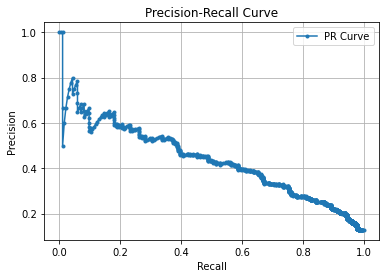

F1 Score: 0.873
PR-AUC Score: 0.442
Accuracy: 0.902
Precision: 0.634
Recall: 0.141
--------------------------------
Confusion Matrix:
 [[1571   15]
 [ 158   26]]
--------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.909   0.991     0.948  1586.000
1                 0.634   0.141     0.231   184.000
accuracy          0.902   0.902     0.902     0.902
macro avg         0.771   0.566     0.589  1770.000
weighted avg      0.880   0.902     0.873  1770.000


In [17]:
# Evaluate Model
evaluate_model(rf_clf_cv, X_test[final_selected_cols], y_test, 0.7)

### GBM

Threshold: 0.64, Precision: 0.83, Recall: 0.05
Adjusted Precision: 0.83, Adjusted Recall: 0.05


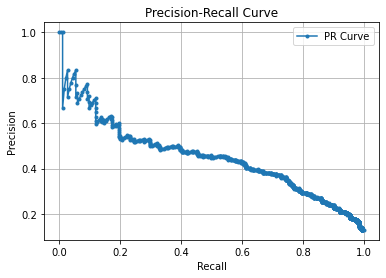

F1 Score: 0.876
PR-AUC Score: 0.455
Accuracy: 0.901
Precision: 0.582
Recall: 0.174
--------------------------------
Confusion Matrix:
 [[1563   23]
 [ 152   32]]
--------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.911   0.985     0.947  1586.000
1                 0.582   0.174     0.268   184.000
accuracy          0.901   0.901     0.901     0.901
macro avg         0.747   0.580     0.607  1770.000
weighted avg      0.877   0.901     0.876  1770.000


In [ ]:
gbm_clf = GradientBoostingClassifier()

gbm_clf.fit(X_train, y_train)

# Evaluate Model
evaluate_model(gbm_clf, X_test, y_test, 0.8)

Threshold: 0.63, Precision: 0.83, Recall: 0.03
Adjusted Precision: 0.83, Adjusted Recall: 0.03


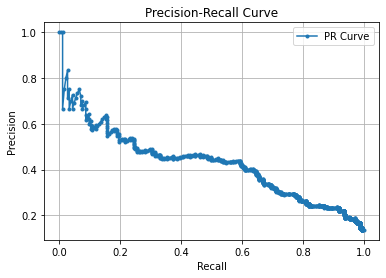

F1 Score: 0.875
PR-AUC Score: 0.431
Accuracy: 0.903
Precision: 0.636
Recall: 0.152
--------------------------------
Confusion Matrix:
 [[1570   16]
 [ 156   28]]
--------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.910   0.990     0.948  1586.000
1                 0.636   0.152     0.246   184.000
accuracy          0.903   0.903     0.903     0.903
macro avg         0.773   0.571     0.597  1770.000
weighted avg      0.881   0.903     0.875  1770.000


In [ ]:
gbm_clf = GradientBoostingClassifier()

gbm_clf.fit(X_train[final_selected_cols], y_train)

# Evaluate Model
evaluate_model(gbm_clf, X_test[final_selected_cols], y_test, 0.8)

In [ ]:
gbm_clf = GradientBoostingClassifier()
param_distributions = {
    'learning_rate': uniform(0.01, 0.29),
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 10)
}

gbm_clf_cv = RandomizedSearchCV(gbm_clf, param_distributions, n_iter = 100, scoring = 'average_precision', cv = 5, random_state = 42, n_jobs =1)
gbm_clf_cv.fit(X_train[final_selected_cols], y_train)

Threshold: 0.56, Precision: 0.71, Recall: 0.16
Adjusted Precision: 0.71, Adjusted Recall: 0.16


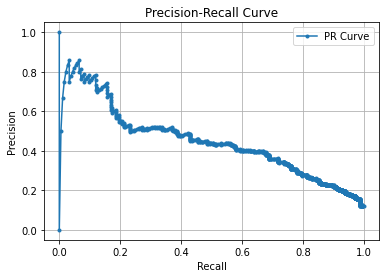

F1 Score : 0.88
PR-AUC-score : 0.45
Precision : 0.57
Recall : 0.2
--------------------------------
Confusion Matrix
 : [[1559   27]
 [ 148   36]]
--------------------------------
Classification Report
               precision  recall  f1-score  support
0                  0.91    0.98      0.95   1586.0
1                  0.57    0.20      0.29    184.0
accuracy           0.90    0.90      0.90      0.9
macro avg          0.74    0.59      0.62   1770.0
weighted avg       0.88    0.90      0.88   1770.0


In [ ]:
# Evaluate Model
evaluate_model(gbm_clf_cv, X_test[final_selected_cols], y_test, 0.7)

### XGBoost

Threshold: 0.71, Precision: 0.70, Recall: 0.18
Adjusted Precision: 0.70, Adjusted Recall: 0.18


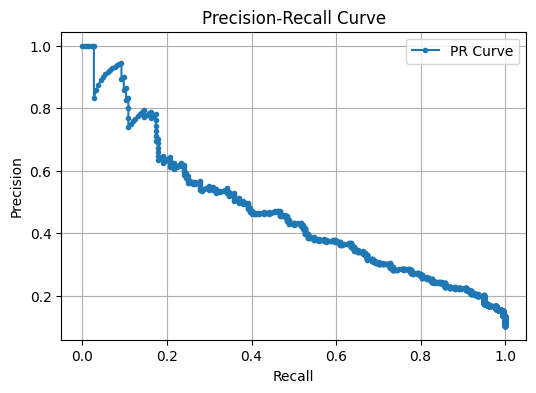

F1 Score: 0.889
PR-AUC Score: 0.47
Accuracy: 0.902
Precision: 0.548
Recall: 0.31
--------------------------------
Confusion Matrix:
 [[1539   47]
 [ 127   57]]
--------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.924   0.970     0.946  1586.000
1                 0.548   0.310     0.396   184.000
accuracy          0.902   0.902     0.902     0.902
macro avg         0.736   0.640     0.671  1770.000
weighted avg      0.885   0.902     0.889  1770.000


In [ ]:
xgb_clf = XGBClassifier(random_state = 42)
# (n_estimators= 100, max_depth = 1, learning_rate= 1.0, random_state=0)
xgb_clf.fit(X_train_scaled, y_train)

# Evaluate Model
evaluate_model(xgb_clf, X_test_scaled, y_test, 0.7)

Threshold: 0.89, Precision: 0.75, Recall: 0.02
Adjusted Precision: 0.75, Adjusted Recall: 0.02


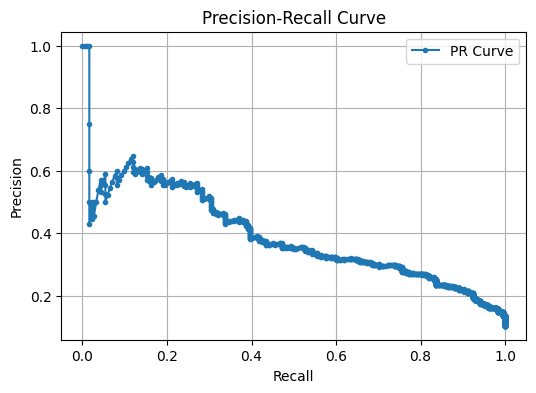

F1 Score: 0.885
PR-AUC Score: 0.395
Accuracy: 0.902
Precision: 0.56
Recall: 0.255
--------------------------------
Confusion Matrix:
 [[1549   37]
 [ 137   47]]
--------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.919   0.977     0.947  1586.000
1                 0.560   0.255     0.351   184.000
accuracy          0.902   0.902     0.902     0.902
macro avg         0.739   0.616     0.649  1770.000
weighted avg      0.881   0.902     0.885  1770.000


In [ ]:
xgb_clf = XGBClassifier(random_state = 42, max_depth = 5, n_estimators = 100)
# (n_estimators= 100, max_depth = 1, learning_rate= 1.0, random_state=0)
xgb_clf.fit(X_train_scaled[final_selected_cols], y_train)

# Evaluate Model
evaluate_model(xgb_clf, X_test_scaled[final_selected_cols], y_test, 0.7)

In [ ]:
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Define the parameter distributions for RandomizedSearchCV
param_distributions = {
    'n_estimators': randint(50, 300),            
    'learning_rate': uniform(0.01, 0.3),         
    'max_depth': randint(3, 10),                
    'min_child_weight': randint(1, 10),        
    'gamma': uniform(0, 0.5),                    
    'subsample': uniform(0.5, 0.5),              
    'colsample_bytree': uniform(0.3, 0.7),
    # 'scale_pos_weight': [scale_pos_weight]
}

# Initialize the XGBClassifier
# xgb_clf = XGBClassifier()

# Set up RandomizedSearchCV with PR-AUC as the scoring metric
xgb_clf_cv = RandomizedSearchCV(
    estimator=XGBClassifier(),
    param_distributions=param_distributions,
    n_iter=100,
    scoring='average_precision',  # Use PR-AUC (average precision) as the scoring metric
    cv=5,
    random_state=42,
    n_jobs=-1
)

xgb_clf_cv.fit(X_train[final_selected_cols], y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f79ba60b150>,
             

Threshold: 0.62, Precision: 0.81, Recall: 0.11
Adjusted Precision: 0.81, Adjusted Recall: 0.11


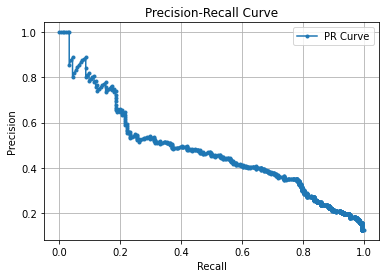

F1 Score : 0.88
PR-AUC-score : 0.48
Precision : 0.62
Recall : 0.22
--------------------------------
Confusion Matrix
 : [[1561   25]
 [ 144   40]]
--------------------------------
Classification Report
               precision  recall  f1-score  support
0                  0.92    0.98      0.95   1586.0
1                  0.62    0.22      0.32    184.0
accuracy           0.90    0.90      0.90      0.9
macro avg          0.77    0.60      0.63   1770.0
weighted avg       0.88    0.90      0.88   1770.0


In [ ]:
# Evaluate Model
evaluate_model(xgb_clf_cv, X_test[final_selected_cols], y_test, desired_precision= 0.8)

### LightGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Threshold: 0.75, Precision: 0.71, Recall: 0.07
Adjusted Precision: 0.71, Adjusted Recall: 0.07


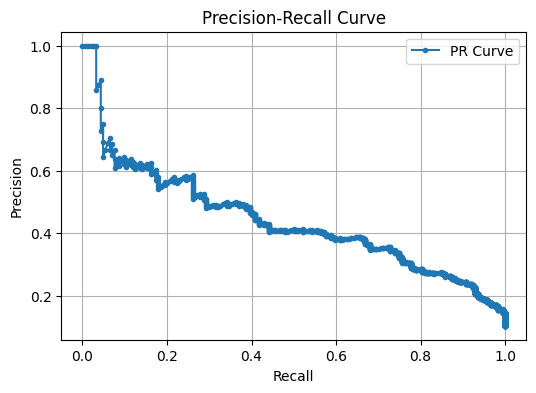

F1 Score: 0.883
PR-AUC Score: 0.443
Accuracy: 0.899
Precision: 0.527
Recall: 0.261
--------------------------------
Confusion Matrix:
 [[1543   43]
 [ 136   48]]
--------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.919   0.973     0.945  1586.000
1                 0.527   0.261     0.349   184.000
accuracy          0.899   0.899     0.899     0.899
macro avg         0.723   0.617     0.647  1770.000
weighted avg      0.878   0.899     0.883  1770.000


In [ ]:
lgbm_clf = LGBMClassifier(random_state=42, verbose = 0)
lgbm_clf.fit(X_train_scaled, y_train)

evaluate_model(lgbm_clf, X_test_scaled, y_test, 0.7)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Threshold: 0.62, Precision: 0.70, Recall: 0.14
Adjusted Precision: 0.70, Adjusted Recall: 0.14


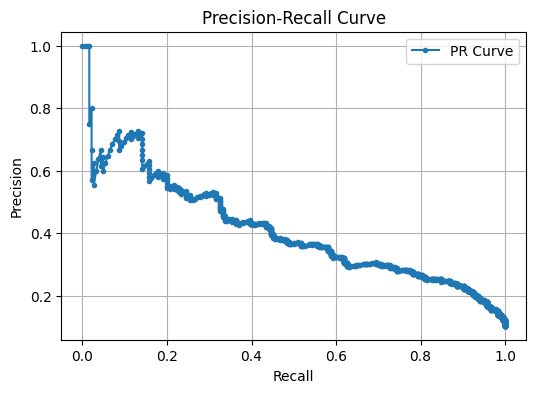

F1 Score: 0.881
PR-AUC Score: 0.415
Accuracy: 0.9
Precision: 0.547
Recall: 0.223
--------------------------------
Confusion Matrix:
 [[1552   34]
 [ 143   41]]
--------------------------------
Classification Report:
               precision  recall  f1-score  support
0                 0.916   0.979     0.946   1586.0
1                 0.547   0.223     0.317    184.0
accuracy          0.900   0.900     0.900      0.9
macro avg         0.731   0.601     0.631   1770.0
weighted avg      0.877   0.900     0.881   1770.0


In [ ]:
lgbm_clf = LGBMClassifier(random_state=42, verbose = 0)
lgbm_clf.fit(X_train_scaled[final_selected_cols], y_train)

evaluate_model(lgbm_clf, X_test_scaled[final_selected_cols], y_test, 0.7)

### CatBoost

#### Original catboost without hyperparam tuning but with selected column

In [ ]:
cb_clf = CatBoostClassifier(verbose = 0, random_state = 42)
# (n_estimators= 100, max_depth = 1, learning_rate= 1.0, random_state=0)
cb_clf.fit(X_train_scaled, y_train)

Threshold: 0.59, Precision: 0.70, Recall: 0.17
Adjusted Precision: 0.70, Adjusted Recall: 0.17


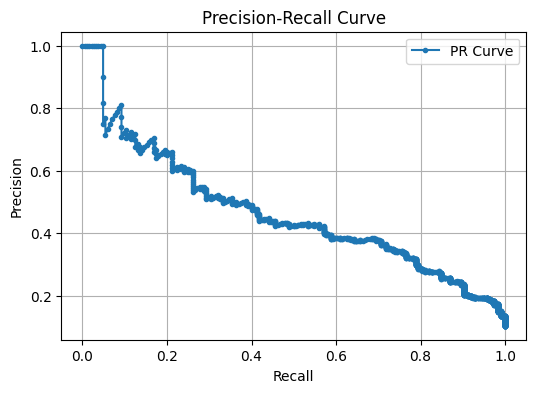

F1 Score: 0.885
PR-AUC Score: 0.468
Accuracy: 0.905
Precision: 0.606
Recall: 0.234
--------------------------------
Confusion Matrix:
 [[1558   28]
 [ 141   43]]
--------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.917   0.982     0.949  1586.000
1                 0.606   0.234     0.337   184.000
accuracy          0.905   0.905     0.905     0.905
macro avg         0.761   0.608     0.643  1770.000
weighted avg      0.885   0.905     0.885  1770.000


In [181]:
#  Evaluate Model
evaluate_model(cb_clf, X_test_scaled, y_test, 0.7)

In [ ]:
cb_clf = CatBoostClassifier(verbose = 0, random_state = 42)
# (n_estimators= 100, max_depth = 1, learning_rate= 1.0, random_state=0)
cb_clf.fit(X_train[final_selected_cols], y_train)

Threshold: 0.59, Precision: 0.71, Recall: 0.13
Adjusted Precision: 0.71, Adjusted Recall: 0.13


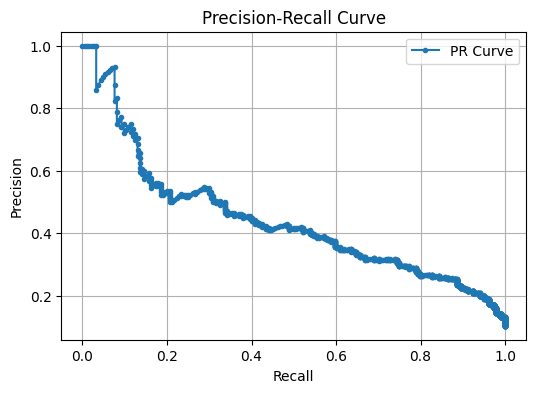

F1 Score: 0.878
PR-AUC Score: 0.443
Accuracy: 0.898
Precision: 0.528
Recall: 0.207
--------------------------------
Confusion Matrix:
 [[1552   34]
 [ 146   38]]
--------------------------------
Classification Report:
               precision  recall  f1-score   support
0                 0.914   0.979     0.945  1586.000
1                 0.528   0.207     0.297   184.000
accuracy          0.898   0.898     0.898     0.898
macro avg         0.721   0.593     0.621  1770.000
weighted avg      0.874   0.898     0.878  1770.000


In [184]:
#  Evaluate Model
evaluate_model(cb_clf, X_test[final_selected_cols], y_test, 0.7)

#### Catboost with hyperparam tuning & with selected column

In [ ]:
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Define the parameter distributions for RandomizedSearchCV for CatBoost
param_distributions = {
    'iterations': randint(50, 300),
    'learning_rate': uniform(0.01, 0.3),
    'depth': randint(3, 10),
    'l2_leaf_reg': uniform(1, 10),
    'bagging_temperature': uniform(0, 1),
    'random_strength': uniform(0, 1),
    'border_count': randint(32, 255),
    'scale_pos_weight': [scale_pos_weight]
}

# Set up RandomizedSearchCV with PR-AUC as the scoring metric
cb_clf_cv = RandomizedSearchCV(
    estimator=cb_clf,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='average_precision',
    cv=5,
    random_state=42,
    n_jobs=1
)

# Fit RandomizedSearchCV
cb_clf_cv.fit(X_train[final_selected_cols], y_train)

# Print the best hyperparameters and score
print("Best Parameters for CatBoost:", cb_clf_cv.best_params_)
print("Best pr-auc Score:", cb_clf_cv.best_score_)

Best Parameters for CatBoost: {'bagging_temperature': 0.07534625600612821, 'border_count': 244, 'depth': 9, 'iterations': 210, 'l2_leaf_reg': 4.169220051562776, 'learning_rate': 0.06084782400582775, 'random_strength': 0.5568012624583502, 'scale_pos_weight': 8.589430894308943}
Best pr-auc Score: 0.4689634793133578


Threshold: 0.91, Precision: 0.72, Recall: 0.07
Adjusted Precision: 0.72, Adjusted Recall: 0.07


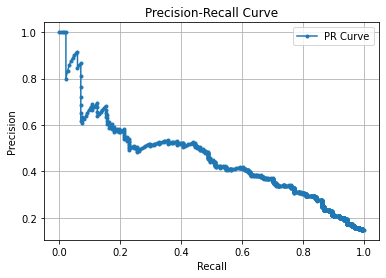

F1 Score: 0.874
PR-AUC Score: 0.461
Accuracy: 0.86
Precision: 0.392
Recall: 0.625
--------------------------------
Confusion Matrix:
 [[1408  178]
 [  69  115]]
--------------------------------
Classification Report:
               precision  recall  f1-score  support
0                 0.953   0.888     0.919  1586.00
1                 0.392   0.625     0.482   184.00
accuracy          0.860   0.860     0.860     0.86
macro avg         0.673   0.756     0.701  1770.00
weighted avg      0.895   0.860     0.874  1770.00


In [ ]:
# Evaluate the parameter optimized, final_selected_columns model
evaluate_model(cb_clf_cv, X_test[final_selected_cols], y_test, 0.7)

### Final Score

- XGBoost Model with all the columns just transformation (29)

	* F1: 0.889
	* PR-AUC: 0.470

- XGBoost Model without Hyperparameter Tuning, Using Only Selected Columns (6)

	* F1: 0.885
	* PR-AUC: 0.395

- XGBoost Model with Hyperparameter Tuning, Using Only Selected Columns (13)

	* F1: 0.874
	* PR-AUC: 0.461

The key takeaway here is that even after dropping certain columns and reducing the model to just 6 features, we still achieved the baseline classifier’s performance. This is remarkable because it means we successfully reduced the model’s complexity while maintaining nearly the same performance, highlighting that we’ve identified the features that genuinely impact the model’s predictions.

Considerations and Future Directions

An important aspect to keep in mind is the threshold. This task is not simply about selecting a model based solely on its score. Instead, we should define the balance between precision and recall through the PR-AUC curve. Adjusting this balance requires setting an appropriate threshold, which involves human judgment.

If a more conservative approach is preferred, we might prioritize precision. On the other hand, if the goal is to increase the number of accepted applicants, we should focus on maximizing recall. Based on these objectives, we would select the model and adjust hyperparameters accordingly to achieve the desired balance.